<a href="https://www.kaggle.com/code/kcwong5/icr-identifying-age-related-conditions-initial?scriptVersionId=138538302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import libraries

In [1]:
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
import sklearn.datasets
import sklearn.metrics

from sklearn.metrics import log_loss
from sklearn.utils.class_weight import compute_sample_weight

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Set notebook environment

In [2]:
# Change notebook environment

# https://ipython.readthedocs.io/en/stable/api/generated/IPython.core.interactiveshell.html
# https://stackoverflow.com/questions/36786722/how-to-display-full-output-in-jupyter-not-only-last-result
# Display full output in output cell, not only last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# https://www.kaggle.com/questions-and-answers/118932
# Max rows and columns of pandas dataframe 
pd.options.display.max_rows,pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option('display.max_rows', None) # Print unlimited number of rows by setting to None, default is 10
pd.set_option('display.max_columns', None) # Do not truncate columns to display all of them by setting to None
pd.set_option('display.width', None) # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option('display.max_colwidth', None) # Auto detect the max size of column and print contents of that column without truncation

# https://stackoverflow.com/questions/8924173/how-to-print-bold-text-in-python
start = "\033[1m" # Bold text
end = "\033[0;0m" # Reset 

import gc

In [3]:
# Free up memory that is no longer being used
gc.collect()

0

# Load datasets

In [4]:
train_df=pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
greeks_df=pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
test_df=pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
sample_submission_df=pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")

# Data glance

In [5]:
print(start+"train.csv:"+end)
train_df.head()
print(start+"\ngreeks.csv:"+end)
greeks_df.head()
print(start+"\ntest.csv:"+end)
test_df.head()
print(start+"\nsample_submission_df.csv:"+end)
sample_submission_df.head()

train.csv:


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1



greeks.csv:


,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020



test.csv:


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



sample_submission_df.csv:


,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


# Check column names

In [6]:
print(start+"train.csv:"+end)
train_df.columns
print(start+"\ngreeks.csv:"+end)
greeks_df.columns
print(start+"\ntest.csv:"+end)
test_df.columns
print(start+"\nsample_submission_df.csv:"+end)
sample_submission_df.columns

train.csv:


Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')


greeks.csv:


Index(['Id', 'Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon'], dtype='object')


test.csv:


Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')


sample_submission_df.csv:


Index(['Id', 'class_0', 'class_1'], dtype='object')

# Assess data
- Attribute
- Summary statistics

In [7]:
print(start+"train:", train_df.shape,end)
print(start+"greeks:", greeks_df.shape,end)
print(start+"test:", test_df.shape,end)
print(start+"sample submission:", sample_submission_df.shape,end)

train: (617, 58) 
greeks: (617, 6) 
test: (5, 57) 
sample submission: (5, 3) 


In [8]:
print(start+"train.csv:"+end)
train_df.info()
print(start+"\ngreeks_df:"+end)
greeks_df.info()
print(start+"\ntest_df:"+end)
test_df.info()
print(start+"\nsample_submission_df:"+end)
sample_submission_df.info()

train.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    floa

In [9]:
print(start+"train_df:"+end)
train_df.describe()
print(start+"\ngreeks_df:"+end)
greeks_df.describe()
print(start+"\ntest_df:"+end)
test_df.describe()
print(start+"\nsample_submission_df:"+end)
sample_submission_df.describe()

train_df:


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,557.000000,617.000000,617.000000,615.000000,614.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,557.000000,617.000000,617.000000,616.000000,617.000000,617.000000,617.000000,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,21.419492,231.322223,98.328737,1218.133238,550.632525,77.104151,0.688801,90.251735,11.241064,0.030615,1.403761,0.742262,36.917590,1.383792,27.165653,51.128326,401.901299,0.633884,0.367002,146.972099,94.795377,26.370568,1.802900,1.924830,26.388989,9.072700,3.064778,1731.248215,0.305107,69.582596,105.060712,69.117005,71.341526,6.930086,10306.810737,10.111079,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,3.478278,183.992505,96.479371,7575.293707,2076.371275,159.049302,0.263994,51.585130,13.571133,0.014808,1.922210,0.281195,17.266347,0.538717,14.645993,21.210888,317.745623,1.912384,0.112989,86.084419,28.243187,8.038825,9.034721,1.484555,18.116679,6.200281,2.058344,1790.227476,1.847499,38.555707,68.445620,390.187057,165.551545,64.754262,11331.294051,2.934025,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,9.886800,72.948951,1.331155,51.216883,257.432377,12.499760,0.176874,23.387600,0.510888,0.003184,1.050225,0.069225,13.784111,0.137925,7.030640,6.906400,35.998895,0.238680,0.040995,60.232470,10.345600,6.339496,0.005518,1.743070,0.804068,4.926396,0.286201,185.594100,0.003042,5.394675,78.526968,3.828384,7.534128,0.296850,1563.136688,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,19.420500,156.847239,27.834425,424.990642,257.432377,23.317567,0.563688,64.724192,5.066306,0.023482,1.050225,0.589575,29.782467,1.070298,7.030640,37.942520,188.815690,0.238680,0.295164,102.703553,78.232240,20.888264,0.005518,1.743070,14.715792,5.965392,1.648679,1111.160625,0.003042,30.927468,78.526968,4.324656,25.815384,0.296850,5164.666260,8.523098,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,21.186000,193.908816,61.642115,627.417402,257.432377,42.554330,0.658715,79.819104,9.123000,0.027860,1.050225,0.730800,34.835130,1.351665,36.019104,49.180940,307.509595,0.238680,0.358023,130.050630,96.264960,25.248800,0.251741,1.743070,21.642456,8.149404,2.616119,1493.817413,0.085176,71.949306,78.526968,22.641144,36.394008,1.870155,7345.143424,9.945452,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,23.657700,247.803462,134.009015,975.649259,257.432377,77.310097,0.772206,99.813520,13.565901,0.034427,1.228445,0.859350,40.529401,1.660617,37.935832,61.408760,507.896200,0.238680,0.426348,165.836955,110.640680,30.544224,1.058690,1.743070,34.058344,10.503048,3.910070,1905.701475,0.237276,109.125159,112.766654,49.085352,56.714448,4.88021


greeks_df:


,Id,Alpha,Beta,Gamma,Delta,Epsilon
count,617,617,617,617,617,617
unique,617,4,3,8,4,198
top,000ff2bfdfe9,A,C,M,B,Unknown
freq,1,509,407,445,456,144



test_df:


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
count,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



sample_submission_df:


,class_0,class_1
count,5.0,5.0
mean,0.5,0.5
std,0.0,0.0
min,0.5,0.5
25%,0.5,0.5
50%,0.5,0.5
75%,0.5,0.5
max,0.5,0.5


# Check missing data

In [10]:
# Check for missing values

print(start+'Check missing values:'+end)

print(start+"\ngreeks_df:"+end)
print(greeks_df.isnull().sum())
print(start+"\ntrain_df:"+end)
print(train_df.isnull().sum())
print(start+"\ntest_df:"+end)
print(test_df.isnull().sum())
print(start+"\nsample_submission_df:"+end)
print(sample_submission_df.isnull().sum())

Check missing values:

greeks_df:
Id         0
Alpha      0
Beta       0
Gamma      0
Delta      0
Epsilon    0
dtype: int64

train_df:
Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

test_df:
Id     0
AB     0
AF     0
AH     0
AM     0
AR     0
AX     0
AY     0
AZ     0
BC     0
BD     0
BN     0
BP     0
BQ     0
BR     0
BZ     0
C

In [11]:
# Keep all rows with at least one missing data
train_df[train_df.isna().any(axis=1)]

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,6569.370010,20.4798,135.881145,NaN,601.802912,257.432377,116.100712,0.855496,93.225352,14.566390,0.033830,1.050225,1.050375,29.914973,1.473039,43.015704,76.77356,231.134460,0.238680,0.330693,131.349555,98.16872,29.466032,0.613833,1.74307,7.200676,10.771632,1.342323,3004.926575,0.066924,B,NaN,78.526968,56.610456,35.300160,1.389258,3380.026318,11.450501,4.762291,1.18262,0.067730,17.245908,147.218610,4589.611956,29.771721,54.675576,0.073416,0
15,07760b4cf3f8,0.666588,3657.78160,304.283751,75.418144,8.138688,12.818973,0.025578,8.167392,1.229900,3597.873030,17.6550,227.744514,NaN,842.371642,257.432377,20.578649,0.651609,373.115464,6.925878,0.051342,1.050225,0.768900,13.784111,1.953018,7.030640,24.32760,647.221725,0.238680,0.333426,117.818145,75.31724,15.927216,0.268983,1.74307,6.446020,4.926396,3.115963,185.594100,0.006084,B,NaN,78.526968,41.357688,41.566224,2.719146,4143.635748,7.723713,67.872762,0.77720,0.582478,4.102182,72.611063,2218.449060,23.806958,35.843392,0.015231,0
18,0b2cc0b0e6c5,0.269199,1586.67784,85.200147,14.459893,8.138688,4.907886,0.032886,7.007824,3.521028,7125.170390,19.7736,176.541633,NaN,700.704062,257.432377,23.317567,0.574937,67.094664,35.649643,0.033432,1.050225,0.621375,33.660011,1.903365,36.658872,57.58308,176.650485,0.238680,0.475542,129.756960,85.36710,21.386416,0.372438,1.74307,17.932064,6.241044,3.970535,1389.371025,0.006084,B,NaN,102.487333,36.673488,32.329920,3.312846,4170.630264,13.727370,97.303580,2.73702,0.711165,16.362218,72.611063,3597.877440,31.330820,25.444796,0.011000,0
23,0cf6c827b8bb,0.371751,2354.54142,105.030540,5.150311,8.138688,10.409325,0.025578,11.526358,2.754976,5435.445190,19.7736,114.529302,NaN,220.658446,257.432377,134.694105,0.780432,56.891328,6.659790,0.023880,1.050225,0.571237,33.109065,1.125468,42.228736,30.65394,149.521590,0.238680,0.409950,96.227752,95.75828,21.270408,0.600039,1.74307,27.686442,4.926396,6.735801,8012.394450,0.121680,B,NaN,78.526968,21.775200,35.808528,2.493540,5709.501083,8.481751,4.648113,0.49706,0.866944,21.664358,198.469061,5987.708568,32.610844,15.019194,0.136552,0
24,0d1b855c7635,0.158101,3257.64549,138.368592,8.640630,18.385464,4.146012,0.182700,4.099451,7.836220,3633.584335,22.2453,170.308184,30.010903,355.723543,2568.243295,NaN,NaN,49.688740,11.840134,0.026069,1.050225,0.731025,57.192031,1.299254,36.817848,42.31334,356.052887,0.901017,0.379887,137.799000,77.89940,15.988632,0.005518,1.74307,23.394336,15.429444,1.130696,559.246525,0.003042,A,87.303431,304.176138,47.280036,117.815712,0.296850,13173.694370,10.358927,0.173229,1.82323,0.433472,8.311337,72.611063,1884.728169,48.039971,37.160256,21.978000,0
45,12d002d52230,1.491277,2434.32640,137.149332,124.242349,8.138688,4.730706,0.025578,4.487024,1.229900,2734.489610,20.4798,129.378519,NaN,2148.501967,257.432377,94.262896,0.715257,210.837232,10.924793,0.044974,1.196620,3.039675,22.717805,1.081332,39.496704,32.13804,556.277615,0.238680,0.308829,264.318060,102.47868,18.820592,0.151734,1.74307,39.264572,7.089204,5.865105,1000.589825,0.006084,B,NaN,102.199994,41.383008,17.867136,0.486834,6448.462858,4.917596,9.126892,2.44238,0.067730,30.919848,72.611063,819.350802,20.156657,31.537864,0.027000,0
46,1319c3883fff,0.243561,3316.81570,85.200147,13.406913,8.138688,3.809370,0.025578,10.505434,4.258968,3042.040690,18.3612,122.748723,NaN,366.787164,257.432377,38.234560,0.650385,85.471768,15.300792,0.018308,1.050225,0.895950,32.474431,1.130985,34.569920,51.10348,802.970055,0.238680,0.396285,129.113145,71.35708,29.186248,0.558657,1.74307,12.977388,4.926396,6.497972,1470.425350,0.042588,B,NaN,78.526968,3.828384,18.901008,3.449397,6946.192026,9.162606,17.726310,0.99586,0.291239,14.585536,160.164837,6209.544726,36.942088,33.093924,0.051333,0
48,135f1

# Check duplication

In [12]:
# Check for duplicates

print(start+'Train set: There are a total of', start+str(train_df.duplicated().sum())+end, start+'duplicate rows.\n'+end)
print(start+'Greeks: There are a total of', start+str(greeks_df.duplicated().sum())+end, start+'duplicate rows.\n'+end)
print(start+'Test set: There are a total of', start+str(test_df.duplicated().sum())+end, start+'duplicate rows.\n'+end)
print(start+'Submission: There are a total of', start+str(sample_submission_df.duplicated().sum())+end, start+'duplicate rows.\n'+end)

Train set: There are a total of 0 duplicate rows.

Greeks: There are a total of 0 duplicate rows.

Test set: There are a total of 0 duplicate rows.

Submission: There are a total of 0 duplicate rows.



In [13]:
# Check duplication by Id
train_df[train_df.Id.duplicated(keep=False)].sort_values("Id")
greeks_df[greeks_df.Id.duplicated(keep=False)].sort_values("Id")

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class


,Id,Alpha,Beta,Gamma,Delta,Epsilon


# Class imbalance

In [14]:
piefreq=train_df.Class.value_counts()

print('Class imbalance (counts): Class 1, Class 0')
print(piefreq,'\n')

# Imbalance class
print('Normalized class: Class 1, Class 0')
print(train_df.Class.value_counts(normalize=True))

# Pie chart of class imbalance
fig=go.Figure(data=[go.Pie(labels=['Class 0    (n=' + str(piefreq[0]) +')',
                                   'Class 1    (n=' + str(piefreq[1]) +')'],
                           values=train_df.Class.value_counts())])
fig.update_layout(title=dict(text="<b>Pie chart of 'Class'</b>",
                             y=0.85,x=0.4,
                             xanchor='center',
                             yanchor='top',
                             font=dict(size=14)
                            )
                  ,width=600
                  ,height=600)

# Delete piefreq dataframe to release memory
del piefreq, fig

Class imbalance (counts): Class 1, Class 0
0    509
1    108
Name: Class, dtype: int64 

Normalized class: Class 1, Class 0
0    0.824959
1    0.175041
Name: Class, dtype: float64


# Merge datasets by Id
- Train and Greek 

In [15]:
# Merge train and greeks dataframe by Id
merged_df = pd.merge(train_df, greeks_df, on="Id")

In [16]:
merged_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


In [17]:
# Categorical feature
merged_df.EJ.value_counts()

B    395
A    222
Name: EJ, dtype: int64

In [18]:
# Categorical feature
print(start+"Alpha:"+end)
greeks_df[~greeks_df["Alpha"].str.isnumeric()]["Alpha"].value_counts()
print("\n"+start+"Beta:"+end)
greeks_df[~greeks_df["Beta"].str.isnumeric()]["Beta"].value_counts()
print("\n"+start+"Gamma:"+end)
greeks_df[~greeks_df["Gamma"].str.isnumeric()]["Gamma"].value_counts()
print("\n"+start+"Delta:"+end)
greeks_df[~greeks_df["Delta"].str.isnumeric()]["Delta"].value_counts()
print("\n"+start+"Epsilon:"+end)
greeks_df[~greeks_df["Epsilon"].str.isnumeric()]["Epsilon"].value_counts()

Alpha:


A    509
B     61
G     29
D     18
Name: Alpha, dtype: int64


Beta:


C    407
B    202
A      8
Name: Beta, dtype: int64


Gamma:


M    445
N     64
H     53
B     18
A     11
F     10
G      8
E      8
Name: Gamma, dtype: int64


Delta:


B    456
A     75
C     64
D     22
Name: Delta, dtype: int64


Epsilon:


Unknown       144
5/29/2019      24
6/26/2019      19
9/15/2020      17
8/29/2019      13
4/24/2019      11
9/8/2020       11
1/29/2019      10
1/31/2019      10
2/18/2019      10
4/30/2020       9
9/13/2020       8
7/30/2020       7
7/27/2020       6
6/11/2020       5
9/14/2020       5
11/27/2018      5
11/25/2019      5
9/11/2020       5
3/1/2019        5
12/10/2018      5
7/28/2020       5
5/6/2020        5
3/15/2019       5
2/28/2019       5
5/27/2020       4
6/21/2019       4
10/1/2019       4
4/29/2020       4
11/30/2018      4
12/4/2018       4
12/20/2018      4
3/13/2019       4
7/24/2020       4
4/28/2020       4
6/2/2020        4
9/7/2020        4
9/16/2020       3
7/16/2020       3
7/29/2020       3
12/24/2019      3
7/19/2019       3
3/7/2019        3
12/30/2019      3
4/9/2019        3
12/19/2019      3
12/9/2019       3
3/28/2019       2
5/2/2020        2
7/30/2019       2
7/15/2020       2
7/15/2019       2
1/28/2020       2
6/25/2020       2
2/22/2019       2
10/18/2019

In [19]:
# Print counts of 'Unknown' Epsilon
unknown_df=greeks_df.query("Epsilon=='Unknown'")
unknown_df.value_counts()

Id            Alpha  Beta  Gamma  Delta  Epsilon
007255e47698  A      C     M      B      Unknown    1
013f2bd269f5  A      C     M      B      Unknown    1
a7b1c7b83f53  A      C     M      B      Unknown    1
ab39fd701211  A      C     M      B      Unknown    1
ab4bc55cb79e  A      C     M      B      Unknown    1
adb67a0dd661  A      C     M      B      Unknown    1
aee064d35f72  A      C     M      B      Unknown    1
af0802c15f01  A      C     M      B      Unknown    1
afad421356e3  A      C     M      B      Unknown    1
b06b043e7abe  A      C     M      B      Unknown    1
b1056bf99b86  A      C     M      B      Unknown    1
b10bae274dfc  A      C     M      B      Unknown    1
b10f6f101138  A      C     M      B      Unknown    1
b301f38c110c  A      C     M      B      Unknown    1
b4d611fab6c5  A      C     M      B      Unknown    1
b874e25c20aa  A      C     M      B      Unknown    1
ba0c42e12f1f  A      C     M      B      Unknown    1
a633a258eeed  A      C     M     

# Pearson Correlation  

<Figure size 3000x1000 with 0 Axes>

[Text(0.5, 0, 'AB'),
 Text(1.5, 0, 'AF'),
 Text(2.5, 0, 'AH'),
 Text(3.5, 0, 'AM'),
 Text(4.5, 0, 'AR'),
 Text(5.5, 0, 'AX'),
 Text(6.5, 0, 'AY'),
 Text(7.5, 0, 'AZ'),
 Text(8.5, 0, 'BC'),
 Text(9.5, 0, 'BD '),
 Text(10.5, 0, 'BN'),
 Text(11.5, 0, 'BP'),
 Text(12.5, 0, 'BQ'),
 Text(13.5, 0, 'BR'),
 Text(14.5, 0, 'BZ'),
 Text(15.5, 0, 'CB'),
 Text(16.5, 0, 'CC'),
 Text(17.5, 0, 'CD '),
 Text(18.5, 0, 'CF'),
 Text(19.5, 0, 'CH'),
 Text(20.5, 0, 'CL'),
 Text(21.5, 0, 'CR'),
 Text(22.5, 0, 'CS'),
 Text(23.5, 0, 'CU'),
 Text(24.5, 0, 'CW '),
 Text(25.5, 0, 'DA'),
 Text(26.5, 0, 'DE'),
 Text(27.5, 0, 'DF'),
 Text(28.5, 0, 'DH'),
 Text(29.5, 0, 'DI'),
 Text(30.5, 0, 'DL'),
 Text(31.5, 0, 'DN'),
 Text(32.5, 0, 'DU'),
 Text(33.5, 0, 'DV'),
 Text(34.5, 0, 'DY'),
 Text(35.5, 0, 'EB'),
 Text(36.5, 0, 'EE'),
 Text(37.5, 0, 'EG'),
 Text(38.5, 0, 'EH'),
 Text(39.5, 0, 'EL'),
 Text(40.5, 0, 'EP'),
 Text(41.5, 0, 'EU'),
 Text(42.5, 0, 'FC'),
 Text(43.5, 0, 'FD '),
 Text(44.5, 0, 'FE'),
 Text(45.5, 0, '

[Text(0, 0, 'AB'),
 Text(0, 1, 'AF'),
 Text(0, 2, 'AH'),
 Text(0, 3, 'AM'),
 Text(0, 4, 'AR'),
 Text(0, 5, 'AX'),
 Text(0, 6, 'AY'),
 Text(0, 7, 'AZ'),
 Text(0, 8, 'BC'),
 Text(0, 9, 'BD '),
 Text(0, 10, 'BN'),
 Text(0, 11, 'BP'),
 Text(0, 12, 'BQ'),
 Text(0, 13, 'BR'),
 Text(0, 14, 'BZ'),
 Text(0, 15, 'CB'),
 Text(0, 16, 'CC'),
 Text(0, 17, 'CD '),
 Text(0, 18, 'CF'),
 Text(0, 19, 'CH'),
 Text(0, 20, 'CL'),
 Text(0, 21, 'CR'),
 Text(0, 22, 'CS'),
 Text(0, 23, 'CU'),
 Text(0, 24, 'CW '),
 Text(0, 25, 'DA'),
 Text(0, 26, 'DE'),
 Text(0, 27, 'DF'),
 Text(0, 28, 'DH'),
 Text(0, 29, 'DI'),
 Text(0, 30, 'DL'),
 Text(0, 31, 'DN'),
 Text(0, 32, 'DU'),
 Text(0, 33, 'DV'),
 Text(0, 34, 'DY'),
 Text(0, 35, 'EB'),
 Text(0, 36, 'EE'),
 Text(0, 37, 'EG'),
 Text(0, 38, 'EH'),
 Text(0, 39, 'EL'),
 Text(0, 40, 'EP'),
 Text(0, 41, 'EU'),
 Text(0, 42, 'FC'),
 Text(0, 43, 'FD '),
 Text(0, 44, 'FE'),
 Text(0, 45, 'FI'),
 Text(0, 46, 'FL'),
 Text(0, 47, 'FR'),
 Text(0, 48, 'FS'),
 Text(0, 49, 'GB'),
 Text(

Text(0.5, 1.0, 'Pearson Correlation Matrix')

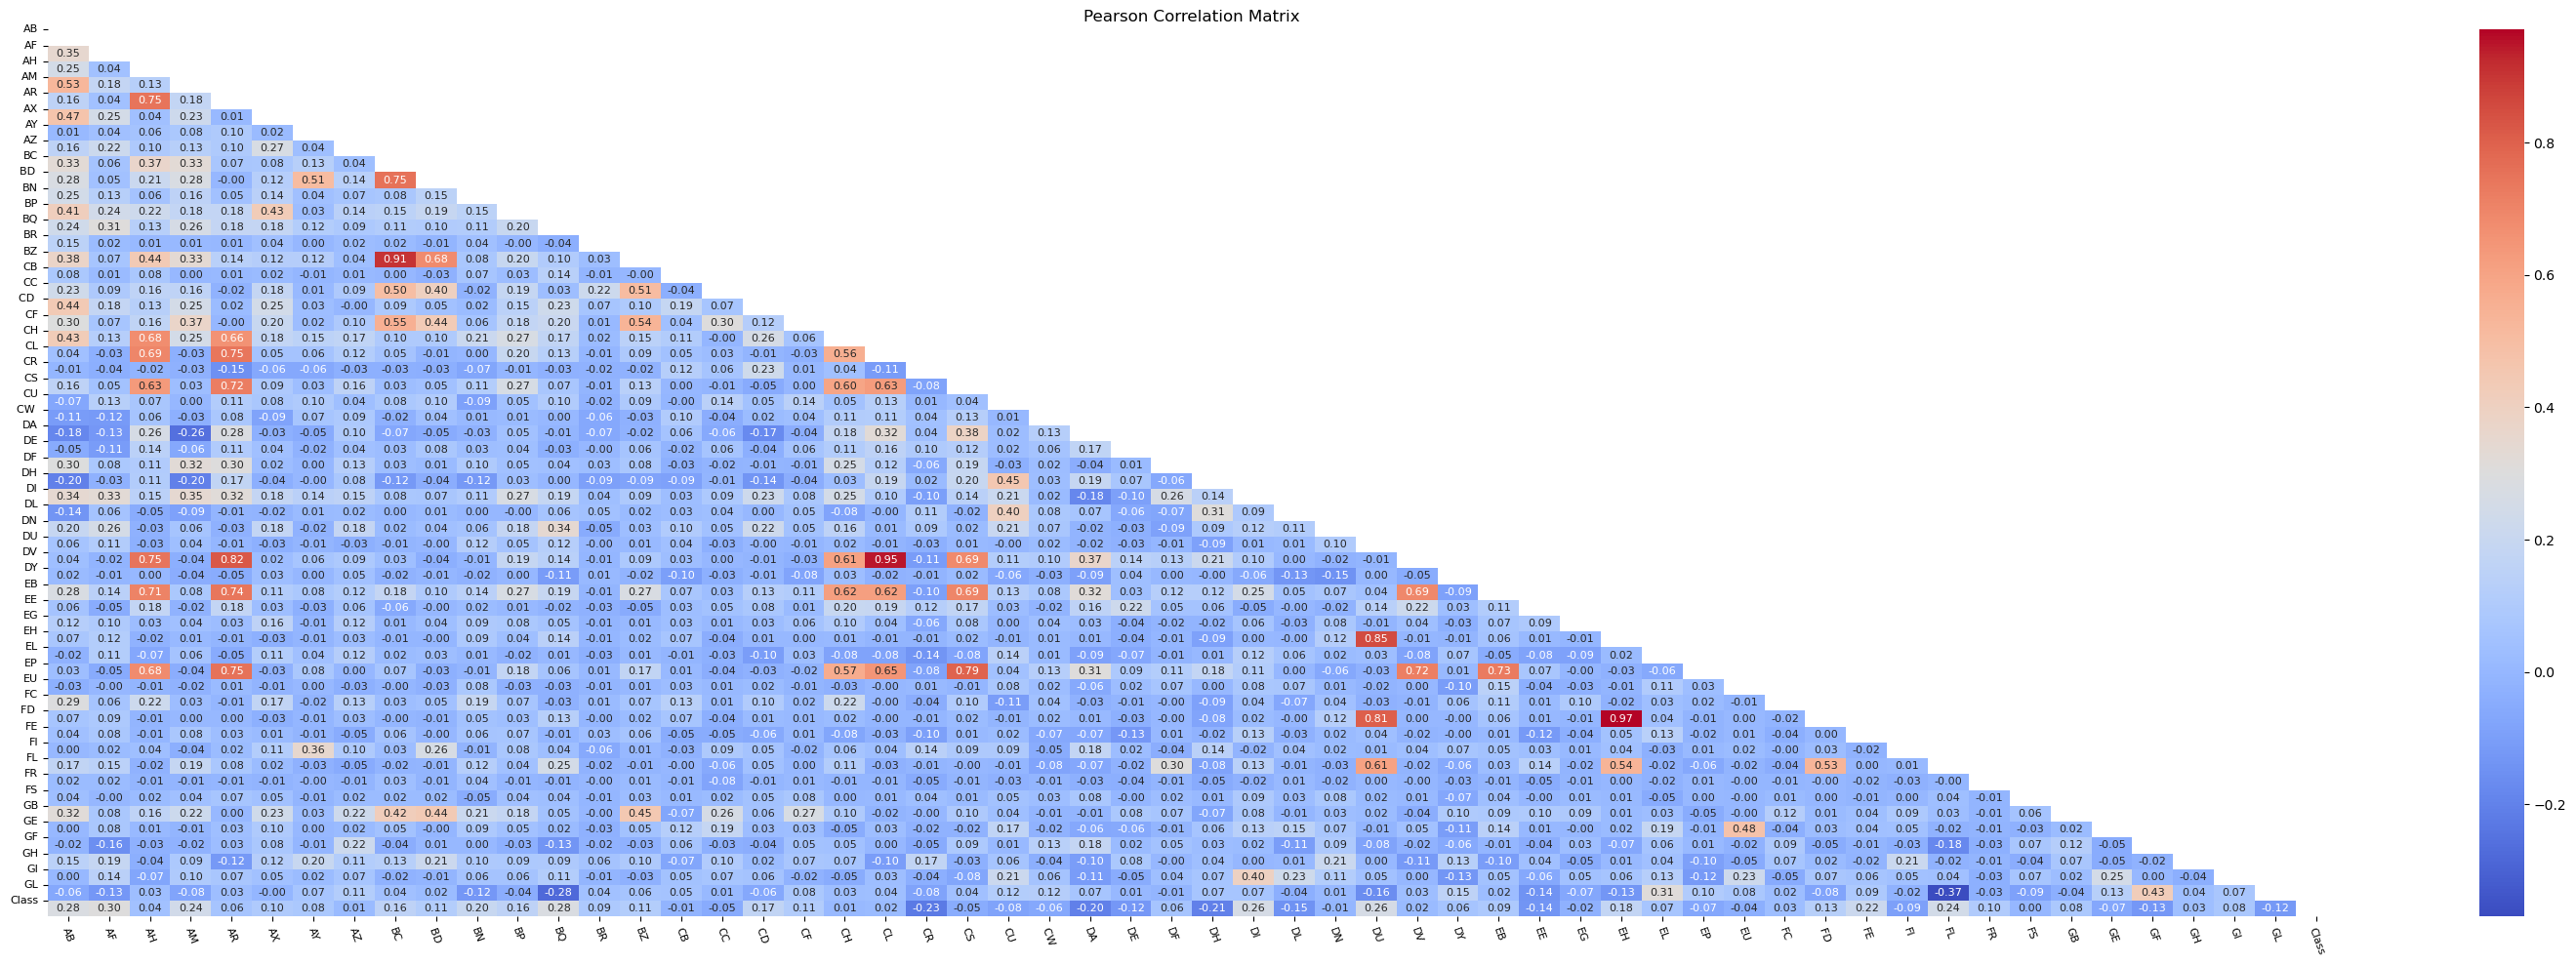

In [20]:
# Heatmap

plt.figure(figsize=(30, 10))

# Compute correlation matrix
corr_matrix = merged_df.select_dtypes(include=np.number).corr()

# Mask off-diagonal values
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask)

# Create heatmap
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 8}, fmt=".2f")

# Update axis labels
labels = corr_matrix.columns
ax.set_xticklabels(labels, rotation=290, ha='center', fontsize=8)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels, rotation=0, va='center', fontsize=8)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_label_coords(0.5, 1.05)
ax.yaxis.set_label_coords(-0.05, 0.5)

plt.title("Pearson Correlation Matrix", fontsize=12)
plt.tight_layout()
plt.show();

del mask, ax, labels, corr_matrix

<Figure size 500x1000 with 0 Axes>

<Axes: >

[Text(0.5, 0, 'Class 0 / Class 1')]

Text(0.5, 1.0, 'Pearson Correlation Matrix with "Class"')

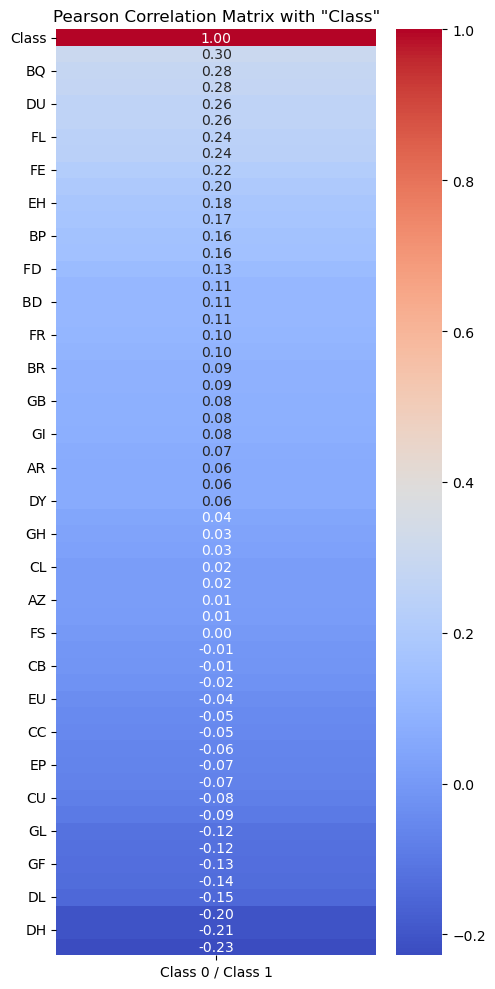

In [21]:
# Compute the correlation matrix
corr_matrix = merged_df.select_dtypes(include=np.number).corr()

# Sort the correlation values in descending order
corr_sorted = corr_matrix['Class'].sort_values(ascending=False)

# Create the heatmap
plt.figure(figsize=(5,10))
sns.heatmap(pd.DataFrame(corr_sorted), annot=True, cmap='coolwarm',annot_kws={"size": 10},fmt=".2f")

ax = plt.gca()
ax.set_xticklabels(['Class 0 / Class 1'], ha='center',fontsize=10)
#ax.set_yticklabels(rotation=0,fontsize=10)

# Add a title
plt.title('Pearson Correlation Matrix with "Class"',fontsize=12)

# Show the plot
plt.tight_layout()
plt.show();

del corr_matrix,ax

# Bar Charts 
- Categorical features by Class

Class    0   1   Class 0   Class 1
EJ                                
A      194  28  0.873874  0.126126
B      315  80  0.797468  0.202532


Text(0.5, 0, 'EJ')

Text(0, 0.5, 'Proportion')

Text(0.5, 1.0, 'Class 0 / Class 1 by EJ')

[Text(0, 0, 'A'), Text(1, 0, 'B')]

Text(0.0, 0.4369369369369369, '87.39%')

Text(1.0, 0.3987341772151899, '79.75%')

Text(0.0, 0.9369369369369369, '12.61%')

Text(1.0, 0.8987341772151899, '20.25%')

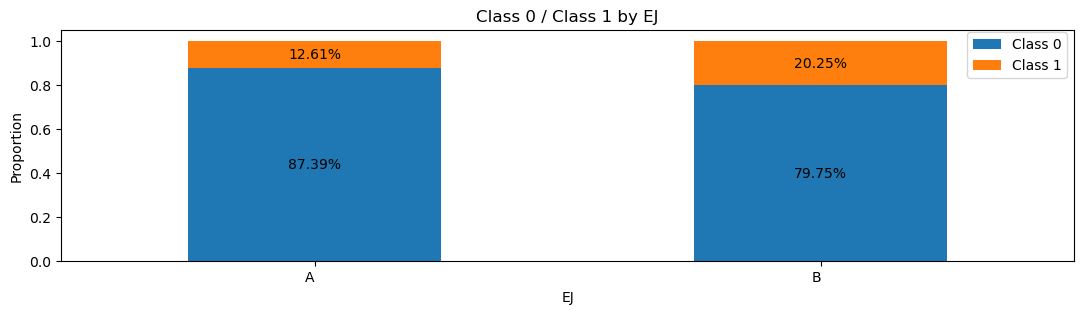

Class      0     1  Class 0  Class 1
Alpha                               
A      509.0   0.0      1.0      0.0
B        0.0  61.0      0.0      1.0
D        0.0  18.0      0.0      1.0
G        0.0  29.0      0.0      1.0


Text(0.5, 0, 'Alpha')

Text(0, 0.5, 'Proportion')

Text(0.5, 1.0, 'Class 0 / Class 1 by Alpha')

[Text(0, 0, 'A'), Text(1, 0, 'B'), Text(2, 0, 'D'), Text(3, 0, 'G')]

Text(0.0, 0.5, '100.00%')

Text(1.0, 0.5, '100.00%')

Text(2.0, 0.5, '100.00%')

Text(3.0, 0.5, '100.00%')

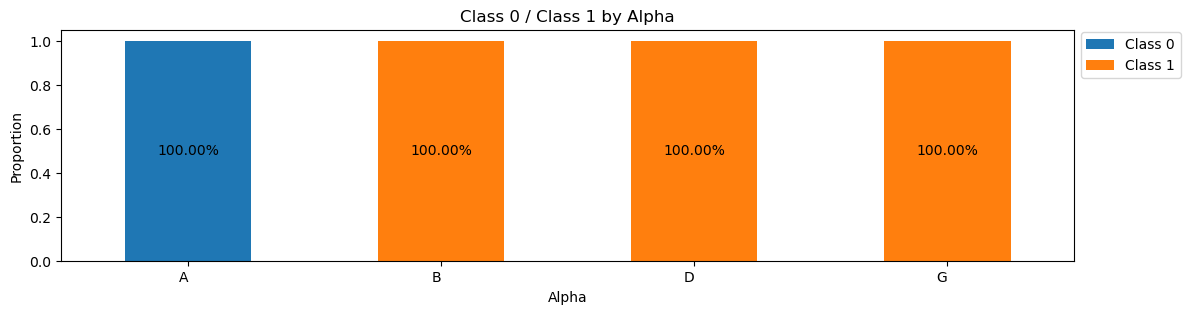

Class      0     1   Class 0   Class 1
Beta                                  
A        0.0   8.0  0.000000  1.000000
B      148.0  54.0  0.732673  0.267327
C      361.0  46.0  0.886978  0.113022


Text(0.5, 0, 'Beta')

Text(0, 0.5, 'Proportion')

Text(0.5, 1.0, 'Class 0 / Class 1 by Beta')

[Text(0, 0, 'A'), Text(1, 0, 'B'), Text(2, 0, 'C')]

Text(1.0, 0.36633663366336633, '73.27%')

Text(2.0, 0.44348894348894347, '88.70%')

Text(0.0, 0.5, '100.00%')

Text(1.0, 0.8663366336633663, '26.73%')

Text(2.0, 0.9434889434889434, '11.30%')

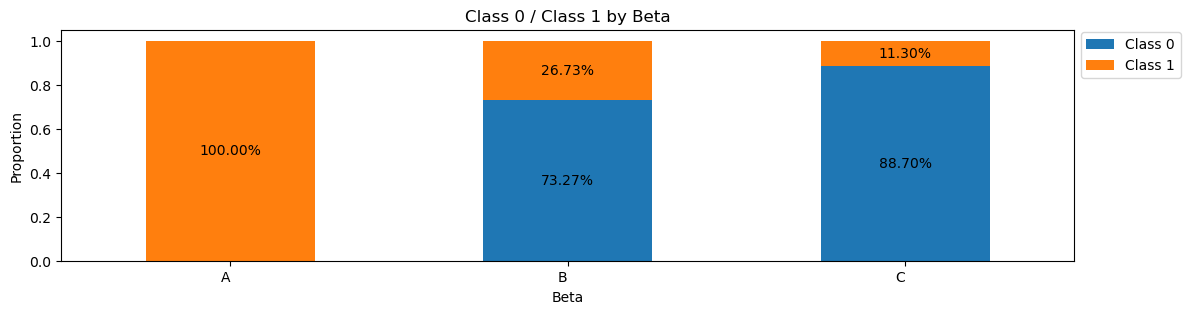

Class      0     1  Class 0  Class 1
Gamma                               
A        0.0  11.0      0.0      1.0
B        0.0  18.0      0.0      1.0
E        0.0   8.0      0.0      1.0
F        0.0  10.0      0.0      1.0
G        0.0   8.0      0.0      1.0
H        0.0  53.0      0.0      1.0
M      445.0   0.0      1.0      0.0
N       64.0   0.0      1.0      0.0


Text(0.5, 0, 'Gamma')

Text(0, 0.5, 'Proportion')

Text(0.5, 1.0, 'Class 0 / Class 1 by Gamma')

[Text(0, 0, 'A'),
 Text(1, 0, 'B'),
 Text(2, 0, 'E'),
 Text(3, 0, 'F'),
 Text(4, 0, 'G'),
 Text(5, 0, 'H'),
 Text(6, 0, 'M'),
 Text(7, 0, 'N')]

Text(6.0, 0.5, '100.00%')

Text(7.0, 0.5, '100.00%')

Text(0.0, 0.5, '100.00%')

Text(1.0, 0.5, '100.00%')

Text(2.0, 0.5, '100.00%')

Text(3.0, 0.5, '100.00%')

Text(4.0, 0.5, '100.00%')

Text(5.0, 0.5, '100.00%')

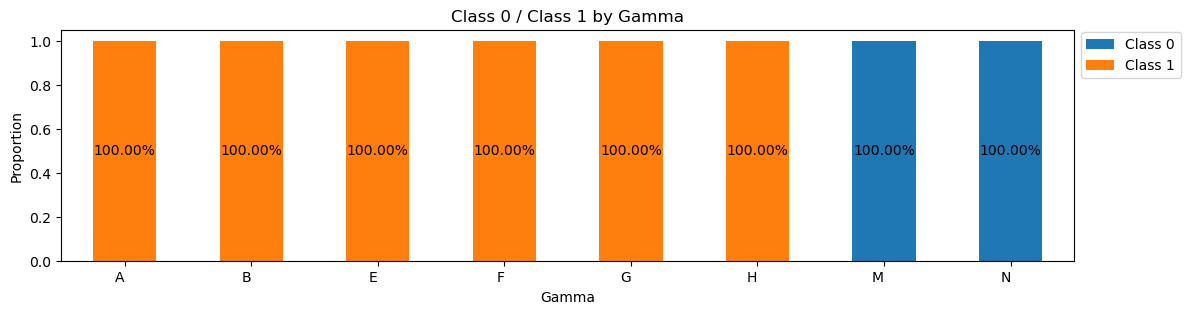

Class    0   1   Class 0   Class 1
Delta                             
A       52  23  0.693333  0.306667
B      402  54  0.881579  0.118421
C       44  20  0.687500  0.312500
D       11  11  0.500000  0.500000


Text(0.5, 0, 'Delta')

Text(0, 0.5, 'Proportion')

Text(0.5, 1.0, 'Class 0 / Class 1 by Delta')

[Text(0, 0, 'A'), Text(1, 0, 'B'), Text(2, 0, 'C'), Text(3, 0, 'D')]

Text(0.0, 0.3466666666666667, '69.33%')

Text(1.0, 0.4407894736842105, '88.16%')

Text(2.0, 0.34375, '68.75%')

Text(3.0, 0.25, '50.00%')

Text(0.0, 0.8466666666666667, '30.67%')

Text(1.0, 0.9407894736842105, '11.84%')

Text(2.0, 0.84375, '31.25%')

Text(3.0, 0.75, '50.00%')

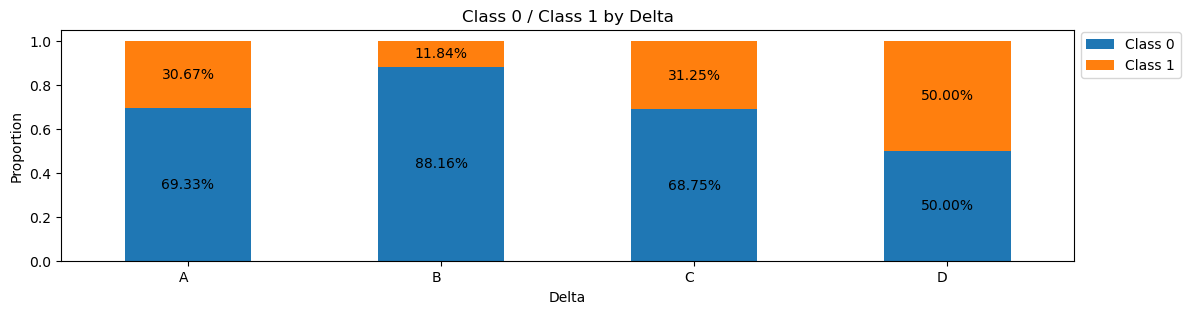

In [22]:
# Define the list of categorical features
categorical_lst = ['EJ','Alpha','Beta', 'Gamma', 'Delta']

for var in categorical_lst:
    # Grouping by the variable and 'Class' column
    var_class = merged_df.groupby([var, 'Class']).size().unstack()
 
    # Replace any empty cells with 0
    var_class = var_class.fillna(0)

    # Calculate the proportion of Class 0 and Class 1 for each value of the variable
    var_class['Class 0'] = var_class[0] / (var_class[0] + var_class[1])
    var_class['Class 1'] = var_class[1] / (var_class[0] + var_class[1])
    print(var_class)
        
    # Plotting the stacked bar chart
    ax = var_class[['Class 0', 'Class 1']].plot(kind='bar', stacked=True, figsize=(15, 3))

    # Adding labels and titles
    ax.set_xlabel(var)
    ax.set_ylabel('Proportion')
    ax.set_title('Class 0 / Class 1 by '+var)
    
    # Rotating x-axis labels by 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=360, ha='right')
    
    # Adding proportion values within each bar
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if height > 0:
            ax.annotate(f'{height:.2%}', (x + width / 2, y + height / 2), ha='center', va='center',fontsize=10)

    # Moving the legend outside the plot area to the top right
    ax.legend(['Class 0', 'Class 1'], loc='best', bbox_to_anchor=(1, 1.02))

    # Adjusting the plot margins
    plt.subplots_adjust(right=0.8)

    # Displaying the chart
    plt.show();


In [23]:
# Quick check
# #len(merged_df[(merged_df['Alpha'] == 'A') & (merged_df['Class'] == 1)])

# Box-whisker plot
- Numerical features by 'Class'

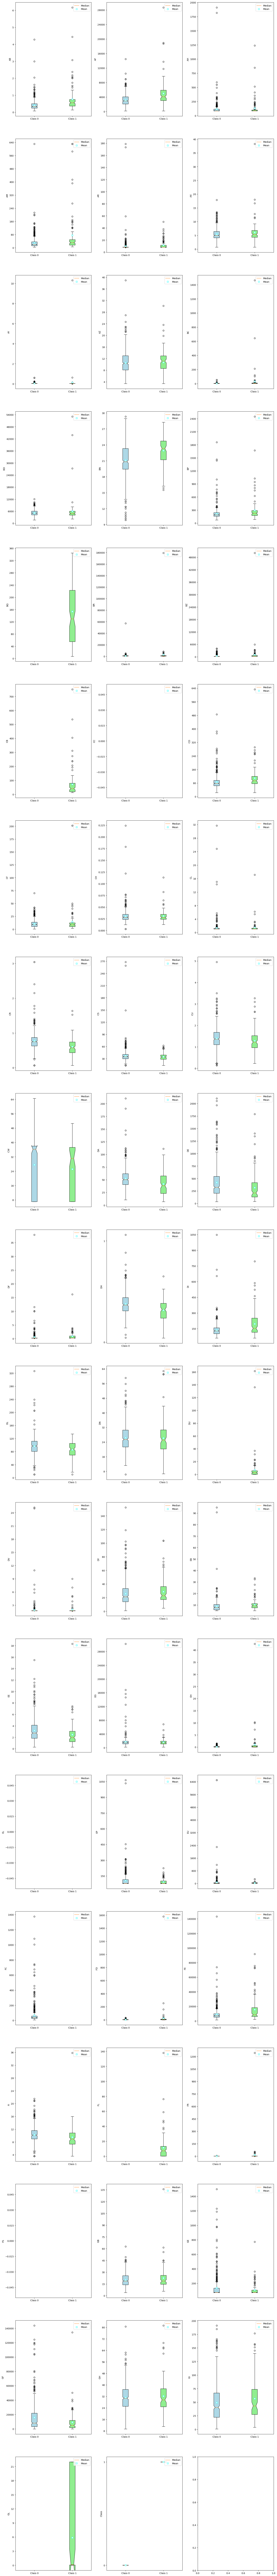

In [24]:
# Define the list of numeric features
numeric_lst = merged_df.select_dtypes(include=np.number).columns.tolist()
y_axis = numeric_lst

# Compute the number of rows and columns for subplot
nrows = len(numeric_lst) // 3 + 1
ncols = 3

# Create the figure and axes for subplot
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 200))

for idx, feature in enumerate(numeric_lst):
    lst0 = merged_df[merged_df['Class'] == 0][feature].tolist()
    #print(f"Feature: {feature}, Length of lst0: {len(lst0)}")
    lst1 = merged_df[merged_df['Class'] == 1][feature].tolist()
    columns = [lst0, lst1]
    
    # Compute the subplot indices
    row_idx = idx // ncols
    col_idx = idx % ncols
    
    # Create the box plot with mean markers
    box = ax[row_idx, col_idx].boxplot(columns, notch=True, patch_artist=True, showmeans=True,
                                       meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "Cyan"})
    
    ax[row_idx, col_idx].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[row_idx, col_idx].set_xticklabels(["Class 0", "Class 1"], size=10)
    ax[row_idx, col_idx].set_ylabel(y_axis[idx], size=10)
    
    colors = ['lightblue', 'lightgreen']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    # Add legend for median and mean markers
    ax[row_idx, col_idx].legend([box["medians"][0], box["means"][0]], ['Median', 'Mean'], loc='upper right')

plt.show();

# Modeling

In [25]:
X_df = merged_df.drop(["Id", "Alpha", "Beta", "Gamma", "Delta","Epsilon","Class"], axis=1)
y_df = merged_df['Class']

In [26]:
X = X_df.to_numpy()
y = y_df.to_numpy()

In [27]:
# Define the column transformer to perform encoding and imputation
preprocessor = ColumnTransformer(transformers=[('cat', 
                                                Pipeline(steps=[('imputer', 
                                                                 SimpleImputer(strategy='most_frequent')
                                                                ),
                                                                ('encoder', 
                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                               sparse_output=False)
                                                                )
                                                               ]
                                                        ),
                                                [39]),  # Use integer column index instead of string column name
                                               ('num', 
                                                SimpleImputer(strategy='median'), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                                                   11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                                                                                   21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                                                                                   31, 32, 33, 34, 35, 36, 37, 38, 40,
                                                                                   41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
                                                                                   51, 52, 53, 54, 55]
                                               )  
                                              ],
                                 remainder='passthrough', sparse_threshold=0) # https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

## A pruner for LightGBM

In [28]:
def objective(trial):
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = []

    # https://lightgbm.readthedocs.io/en/latest/Parameters.html#objective-parameters
    param = {"objective": "binary",
             "metric": "binary_logloss",
             "verbosity": -1,
             "boosting_type": "gbdt",
             "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
             "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
             "num_leaves": trial.suggest_int("num_leaves", 2, 256),
             "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
             "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
             "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
             "pos_bagging_fraction": trial.suggest_float("pos_bagging_fraction", 0.4, 1.0),
             "neg_bagging_fraction": trial.suggest_float("neg_bagging_fraction", 0.4, 1.0),
             "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
             "seed": 42,
             "learning_rate":trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True),
             "is_unbalance":True,
            }

    # Enumerate the splits and summarize the distributions
    for train_index, valid_index in skf.split(X, y):
        
        # Select rows
        train_x, valid_x = X[train_index], X[valid_index]
        train_y, valid_y = y[train_index], y[valid_index]
        
        # Summarize train and test composition
        train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
        valid_0, valid_1 = len(valid_y[valid_y==0]), len(valid_y[valid_y==1])
        print('>Train: 0=%d, 1=%d, Valid: 0=%d, 1=%d' % (train_0, train_1, valid_0, valid_1))
        
        # Fit the preprocessor on the training data
        preprocessor.fit(train_x)
        
        # Transform the training and validation data
        train_x = preprocessor.transform(train_x)
        valid_x = preprocessor.transform(valid_x)
    
        dtrain = lgb.Dataset(train_x,label=train_y)
        dvalid = lgb.Dataset(valid_x,label=valid_y)

        # Add a callback for pruning.
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "binary_logloss") 

        gbm = lgb.train(param, 
                        dtrain, valid_sets=[dvalid],
                        callbacks=[pruning_callback])

        preds = gbm.predict(valid_x)
                
        # https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html#sklearn.utils.class_weight.compute_sample_weight
        # Calculate sample weights for an imbalanced dataset
        sample_weight = compute_sample_weight('balanced', valid_y)

        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss
        # Calculate log loss with sample weights
        log_loss_weighted = log_loss(valid_y, preds,  
                                     eps=1e-15,
                                     sample_weight=sample_weight)
        
        return log_loss_weighted

if __name__ == "__main__":
    # https://optuna.readthedocs.io/en/stable/faq.html#how-can-i-obtain-reproducible-optimization-results
    # Make the sampler behave in a deterministic way
    sampler = TPESampler(seed=42)  
    study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize",sampler=sampler)
    study.optimize(objective, n_trials=300)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-08-01 05:16:04,139] A new study created in memory with name: no-name-2fb877a0-05ee-4e85-95ba-6a70acef18e4


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:04,548] Trial 0 finished with value: 0.6398841686466716 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'num_leaves': 188, 'feature_fraction': 0.759195090518222, 'bagging_fraction': 0.4936111842654619, 'bagging_freq': 2, 'pos_bagging_fraction': 0.4348501673009197, 'neg_bagging_fraction': 0.9197056874649611, 'min_child_samples': 62, 'learning_rate': 0.006796578090758156}. Best is trial 0 with value: 0.6398841686466716.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:05,001] Trial 1 finished with value: 0.9544326794478387 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285, 'num_leaves': 214, 'feature_fraction': 0.5274034664069657, 'bagging_fraction': 0.5090949803242604, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5825453457757226, 'neg_bagging_fraction': 0.7148538589793427, 'min_child_samples': 46, 'learning_rate': 0.0001461896279370495}. Best is trial 0 with value: 0.6398841686466716.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:05,316] Trial 2 finished with value: 0.9670592585663722 and parameters: {'lambda_l1': 0.0032112643094417484, 'lambda_l2': 1.8007140198129195e-07, 'num_leaves': 76, 'feature_fraction': 0.619817105976215, 'bagging_fraction': 0.6736419905302216, 'bagging_freq': 6, 'pos_bagging_fraction': 0.5198042692950159, 'neg_bagging_fraction': 0.708540663048167, 'min_child_samples': 61, 'learning_rate': 1.5339162591163613e-05}. Best is trial 0 with value: 0.6398841686466716.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:05,567] Trial 3 finished with value: 0.8916213580154678 and parameters: {'lambda_l1': 0.0029369981104377003, 'lambda_l2': 3.425445902633376e-07, 'num_leaves': 18, 'feature_fraction': 0.9693313223519999, 'bagging_fraction': 0.9793792198447356, 'bagging_freq': 6, 'pos_bagging_fraction': 0.5827682615040224, 'neg_bagging_fraction': 0.45860326840383037, 'min_child_samples': 70, 'learning_rate': 0.00057624872164786}. Best is trial 0 with value: 0.6398841686466716.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:05,878] Trial 4 finished with value: 0.9613049016511503 and parameters: {'lambda_l1': 1.254134495897175e-07, 'lambda_l2': 0.00028614897264046574, 'num_leaves': 10, 'feature_fraction': 0.9455922412472693, 'bagging_fraction': 0.5552679889600102, 'bagging_freq': 5, 'pos_bagging_fraction': 0.5870266456536466, 'neg_bagging_fraction': 0.7120408127066865, 'min_child_samples': 57, 'learning_rate': 5.4880470007660426e-05}. Best is trial 0 with value: 0.6398841686466716.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:06,372] Trial 5 finished with value: 0.9465216471047849 and parameters: {'lambda_l1': 5.324289357128436, 'lambda_l2': 0.09466630153726856, 'num_leaves': 241, 'feature_fraction': 0.9368964102565893, 'bagging_fraction': 0.7587399872866512, 'bagging_freq': 7, 'pos_bagging_fraction': 0.4530955012311517, 'neg_bagging_fraction': 0.5175897174514872, 'min_child_samples': 9, 'learning_rate': 0.0002001342062287998}. Best is trial 0 with value: 0.6398841686466716.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:07,377] Trial 6 finished with value: 0.6857185985511708 and parameters: {'lambda_l1': 3.148441347423712e-05, 'lambda_l2': 2.7678419414850017e-06, 'num_leaves': 213, 'feature_fraction': 0.6140519960161536, 'bagging_fraction': 0.5685607058124285, 'bagging_freq': 4, 'pos_bagging_fraction': 0.4845545349848576, 'neg_bagging_fraction': 0.8813181884524238, 'min_child_samples': 12, 'learning_rate': 0.08862326508576249}. Best is trial 0 with value: 0.6398841686466716.
[I 2023-08-01 05:16:07,436] Trial 7 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:07,752] Trial 8 finished with value: 0.88243956942454 and parameters: {'lambda_l1': 0.5860448217200517, 'lambda_l2': 0.004070831640873338, 'num_leaves': 86, 'feature_fraction': 0.4381350101716142, 'bagging_fraction': 0.5865893930293973, 'bagging_freq': 3, 'pos_bagging_fraction': 0.8377637070028385, 'neg_bagging_fraction': 0.7825344828131279, 'min_child_samples': 90, 'learning_rate': 0.0007742116473996246}. Best is trial 0 with value: 0.6398841686466716.
[I 2023-08-01 05:16:07,876] Trial 9 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:08,356] Trial 10 finished with value: 0.60830737803335 and parameters: {'lambda_l1': 2.3457929170351198e-05, 'lambda_l2': 2.487470846788633, 'num_leaves': 152, 'feature_fraction': 0.7925015835643137, 'bagging_fraction': 0.4092206423968626, 'bagging_freq': 1, 'pos_bagging_fraction': 0.40908654226165414, 'neg_bagging_fraction': 0.9856839399147971, 'min_child_samples': 95, 'learning_rate': 0.008987153901963656}. Best is trial 10 with value: 0.60830737803335.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:08,776] Trial 11 finished with value: 0.6343058934031836 and parameters: {'lambda_l1': 1.302013103054208e-05, 'lambda_l2': 3.253025590604337, 'num_leaves': 157, 'feature_fraction': 0.788028895181074, 'bagging_fraction': 0.41022523369707764, 'bagging_freq': 1, 'pos_bagging_fraction': 0.4064948381096366, 'neg_bagging_fraction': 0.9993649835283197, 'min_child_samples': 96, 'learning_rate': 0.007887826251941597}. Best is trial 10 with value: 0.60830737803335.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:09,194] Trial 12 finished with value: 0.7234538311379072 and parameters: {'lambda_l1': 1.0024983618567058e-05, 'lambda_l2': 9.746600385105031, 'num_leaves': 140, 'feature_fraction': 0.8060908348573689, 'bagging_fraction': 0.4163879796747685, 'bagging_freq': 1, 'pos_bagging_fraction': 0.40190150290937926, 'neg_bagging_fraction': 0.9976099190484612, 'min_child_samples': 99, 'learning_rate': 0.006097028910019557}. Best is trial 10 with value: 0.60830737803335.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:09,632] Trial 13 finished with value: 0.6218699795835263 and parameters: {'lambda_l1': 2.6491362420564193e-06, 'lambda_l2': 0.27161810973596784, 'num_leaves': 146, 'feature_fraction': 0.8337042013583905, 'bagging_fraction': 0.4159650786776957, 'bagging_freq': 1, 'pos_bagging_fraction': 0.40788418943068494, 'neg_bagging_fraction': 0.9792027676392733, 'min_child_samples': 82, 'learning_rate': 0.007037437893019667}. Best is trial 10 with value: 0.60830737803335.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:10,112] Trial 14 finished with value: 0.6827511994724734 and parameters: {'lambda_l1': 5.385659685389972e-07, 'lambda_l2': 0.1535714491181795, 'num_leaves': 107, 'feature_fraction': 0.8739794131187998, 'bagging_fraction': 0.41566649125817917, 'bagging_freq': 2, 'pos_bagging_fraction': 0.987677839776488, 'neg_bagging_fraction': 0.8865004562355121, 'min_child_samples': 79, 'learning_rate': 0.0030093498978634044}. Best is trial 10 with value: 0.60830737803335.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:10,538] Trial 15 finished with value: 0.3507717278231102 and parameters: {'lambda_l1': 1.8251623370246791e-06, 'lambda_l2': 0.31856132881420873, 'num_leaves': 157, 'feature_fraction': 0.8411589973565382, 'bagging_fraction': 0.6600044055220933, 'bagging_freq': 1, 'pos_bagging_fraction': 0.4825500516531853, 'neg_bagging_fraction': 0.8288158877790732, 'min_child_samples': 85, 'learning_rate': 0.027453612584523012}. Best is trial 15 with value: 0.3507717278231102.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:10,976] Trial 16 finished with value: 0.2991685370434252 and parameters: {'lambda_l1': 0.0003474444210156447, 'lambda_l2': 0.002557687335165542, 'num_leaves': 171, 'feature_fraction': 0.7289483756189898, 'bagging_fraction': 0.661723702622221, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5159145811621062, 'neg_bagging_fraction': 0.8138046551270604, 'min_child_samples': 81, 'learning_rate': 0.04071652118027245}. Best is trial 16 with value: 0.2991685370434252.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:11,451] Trial 17 finished with value: 0.2615863051058111 and parameters: {'lambda_l1': 0.00040777902462325383, 'lambda_l2': 0.0010825255176985578, 'num_leaves': 256, 'feature_fraction': 0.7032985332677887, 'bagging_fraction': 0.6632929152403992, 'bagging_freq': 3, 'pos_bagging_fraction': 0.508774450835003, 'neg_bagging_fraction': 0.793626300652922, 'min_child_samples': 76, 'learning_rate': 0.06877181657541481}. Best is trial 17 with value: 0.2615863051058111.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:11,924] Trial 18 finished with value: 0.2754104911729129 and parameters: {'lambda_l1': 0.00040599973475969724, 'lambda_l2': 0.0002458152801571884, 'num_leaves': 254, 'feature_fraction': 0.6738835734350274, 'bagging_fraction': 0.732779622323091, 'bagging_freq': 3, 'pos_bagging_fraction': 0.538450919419236, 'neg_bagging_fraction': 0.8079137079365308, 'min_child_samples': 70, 'learning_rate': 0.09087845133833547}. Best is trial 17 with value: 0.2615863051058111.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:12,479] Trial 19 finished with value: 0.2347652830312867 and parameters: {'lambda_l1': 0.0005265622475910979, 'lambda_l2': 4.242119292870835e-05, 'num_leaves': 256, 'feature_fraction': 0.6673297675302176, 'bagging_fraction': 0.7348607997534249, 'bagging_freq': 3, 'pos_bagging_fraction': 0.6584651161873948, 'neg_bagging_fraction': 0.6370467822084508, 'min_child_samples': 36, 'learning_rate': 0.07742230169721102}. Best is trial 19 with value: 0.2347652830312867.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:12,994] Trial 20 finished with value: 0.31481725197962745 and parameters: {'lambda_l1': 0.014504522003258998, 'lambda_l2': 2.6894244332221912e-05, 'num_leaves': 224, 'feature_fraction': 0.6836781117376376, 'bagging_fraction': 0.630584999373574, 'bagging_freq': 5, 'pos_bagging_fraction': 0.642739854468289, 'neg_bagging_fraction': 0.6200747892749875, 'min_child_samples': 34, 'learning_rate': 0.02524373582670851}. Best is trial 19 with value: 0.2347652830312867.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:13,709] Trial 21 finished with value: 0.34663504880255375 and parameters: {'lambda_l1': 0.0002482392614057073, 'lambda_l2': 9.360590232849835e-05, 'num_leaves': 253, 'feature_fraction': 0.6703408659384753, 'bagging_fraction': 0.7288764283068369, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5437203668345908, 'neg_bagging_fraction': 0.7465548799232171, 'min_child_samples': 24, 'learning_rate': 0.0954975022061644}. Best is trial 19 with value: 0.2347652830312867.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:14,151] Trial 22 finished with value: 0.22205877825882078 and parameters: {'lambda_l1': 0.0005301458075025844, 'lambda_l2': 1.3311706099419597e-05, 'num_leaves': 256, 'feature_fraction': 0.6487550539569624, 'bagging_fraction': 0.7268878873533379, 'bagging_freq': 3, 'pos_bagging_fraction': 0.641045809490872, 'neg_bagging_fraction': 0.6306249916963769, 'min_child_samples': 74, 'learning_rate': 0.09642896668687348}. Best is trial 22 with value: 0.22205877825882078.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:14,690] Trial 23 finished with value: 0.2713429170662598 and parameters: {'lambda_l1': 0.002007597174191225, 'lambda_l2': 1.925727791846737e-08, 'num_leaves': 230, 'feature_fraction': 0.607018337979075, 'bagging_fraction': 0.7666132891296144, 'bagging_freq': 4, 'pos_bagging_fraction': 0.6709686614283311, 'neg_bagging_fraction': 0.6128730530891233, 'min_child_samples': 49, 'learning_rate': 0.03796205584174268}. Best is trial 22 with value: 0.22205877825882078.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:15,305] Trial 24 finished with value: 0.356990305339157 and parameters: {'lambda_l1': 0.0001554030842728698, 'lambda_l2': 2.228765095355298e-05, 'num_leaves': 199, 'feature_fraction': 0.7123384888329835, 'bagging_fraction': 0.7098209982329854, 'bagging_freq': 2, 'pos_bagging_fraction': 0.715698311424656, 'neg_bagging_fraction': 0.5523977161079254, 'min_child_samples': 70, 'learning_rate': 0.01952353293231525}. Best is trial 22 with value: 0.22205877825882078.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:16,118] Trial 25 finished with value: 0.25522879103339274 and parameters: {'lambda_l1': 0.0211246461664238, 'lambda_l2': 0.0010646376064612777, 'num_leaves': 237, 'feature_fraction': 0.5495635460369939, 'bagging_fraction': 0.6181231633641157, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5991534922487002, 'neg_bagging_fraction': 0.6584370796795951, 'min_child_samples': 28, 'learning_rate': 0.04925660010679635}. Best is trial 22 with value: 0.22205877825882078.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:16,727] Trial 26 finished with value: 0.3791360983402691 and parameters: {'lambda_l1': 0.025012859209327453, 'lambda_l2': 8.432518390829549e-06, 'num_leaves': 239, 'feature_fraction': 0.5526847326067964, 'bagging_fraction': 0.8045259699072969, 'bagging_freq': 5, 'pos_bagging_fraction': 0.6289469356772752, 'neg_bagging_fraction': 0.6557560139051981, 'min_child_samples': 22, 'learning_rate': 0.01579173833545089}. Best is trial 22 with value: 0.22205877825882078.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:17,333] Trial 27 finished with value: 0.276437024821326 and parameters: {'lambda_l1': 0.05223318646515932, 'lambda_l2': 6.15451267933524e-05, 'num_leaves': 223, 'feature_fraction': 0.5472098076451519, 'bagging_fraction': 0.6086662004806684, 'bagging_freq': 4, 'pos_bagging_fraction': 0.6895561766776683, 'neg_bagging_fraction': 0.6068871763189548, 'min_child_samples': 27, 'learning_rate': 0.047133269756878364}. Best is trial 22 with value: 0.22205877825882078.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:17,863] Trial 28 finished with value: 0.25402642882861204 and parameters: {'lambda_l1': 0.0047777506453616815, 'lambda_l2': 0.0006284166028161541, 'num_leaves': 178, 'feature_fraction': 0.4878139367923305, 'bagging_fraction': 0.708745076188375, 'bagging_freq': 3, 'pos_bagging_fraction': 0.7530033056133155, 'neg_bagging_fraction': 0.6679580333106633, 'min_child_samples': 39, 'learning_rate': 0.04816533121247186}. Best is trial 22 with value: 0.22205877825882078.
[I 2023-08-01 05:16:18,071] Trial 29 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:18,237] Trial 30 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:18,822] Trial 31 finished with value: 0.25958567336976685 and parameters: {'lambda_l1': 0.0056177127840860005, 'lambda_l2': 0.0007337951070722277, 'num_leaves': 202, 'feature_fraction': 0.4978958431679142, 'bagging_fraction': 0.6328287732971127, 'bagging_freq': 3, 'pos_bagging_fraction': 0.6392742439377342, 'neg_bagging_fraction': 0.665310422942979, 'min_child_samples': 31, 'learning_rate': 0.039460659314846325}. Best is trial 22 with value: 0.22205877825882078.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:19,669] Trial 32 finished with value: 0.28330552402820147 and parameters: {'lambda_l1': 0.009767125065658707, 'lambda_l2': 0.00045870843137874826, 'num_leaves': 237, 'feature_fraction': 0.575813932089164, 'bagging_fraction': 0.698665065441649, 'bagging_freq': 4, 'pos_bagging_fraction': 0.6067515341405463, 'neg_bagging_fraction': 0.669064213582626, 'min_child_samples': 18, 'learning_rate': 0.05776479781957963}. Best is trial 22 with value: 0.22205877825882078.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:20,260] Trial 33 finished with value: 0.25461081191613416 and parameters: {'lambda_l1': 0.0010485900395509468, 'lambda_l2': 0.006074446130534024, 'num_leaves': 213, 'feature_fraction': 0.40718264965673806, 'bagging_fraction': 0.5391581383931565, 'bagging_freq': 3, 'pos_bagging_fraction': 0.661430373798645, 'neg_bagging_fraction': 0.7380777466577695, 'min_child_samples': 37, 'learning_rate': 0.09985324109221928}. Best is trial 22 with value: 0.22205877825882078.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:20,839] Trial 34 finished with value: 0.26629397141212735 and parameters: {'lambda_l1': 0.0009181629375576414, 'lambda_l2': 0.010829516823005729, 'num_leaves': 212, 'feature_fraction': 0.41558068382965346, 'bagging_fraction': 0.5377881765089441, 'bagging_freq': 2, 'pos_bagging_fraction': 0.6655508551564121, 'neg_bagging_fraction': 0.7373740562946868, 'min_child_samples': 36, 'learning_rate': 0.09519060956892188}. Best is trial 22 with value: 0.22205877825882078.
[I 2023-08-01 05:16:21,142] Trial 35 pruned. Trial was pruned at iteration 40.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:21,604] Trial 36 finished with value: 0.2617412286575437 and parameters: {'lambda_l1': 0.0011629208995974495, 'lambda_l2': 0.00022465726528360903, 'num_leaves': 122, 'feature_fraction': 0.40258396423077963, 'bagging_fraction': 0.499129488295474, 'bagging_freq': 4, 'pos_bagging_fraction': 0.7516892234950129, 'neg_bagging_fraction': 0.7412906199208873, 'min_child_samples': 61, 'learning_rate': 0.053091352724651604}. Best is trial 22 with value: 0.22205877825882078.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:22,210] Trial 37 finished with value: 0.254364508009915 and parameters: {'lambda_l1': 0.00013124773662998382, 'lambda_l2': 1.6654001830060778e-06, 'num_leaves': 171, 'feature_fraction': 0.6455997055732429, 'bagging_fraction': 0.4708687602409539, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5658745924762625, 'neg_bagging_fraction': 0.692699093712077, 'min_child_samples': 53, 'learning_rate': 0.061601278484675046}. Best is trial 22 with value: 0.22205877825882078.
[I 2023-08-01 05:16:22,388] Trial 38 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:22,877] Trial 39 finished with value: 0.23268254825284887 and parameters: {'lambda_l1': 4.532924768415683e-05, 'lambda_l2': 9.930123279161595e-07, 'num_leaves': 166, 'feature_fraction': 0.5948453757460168, 'bagging_fraction': 0.5851087380325477, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5667065140801251, 'neg_bagging_fraction': 0.48666569013201877, 'min_child_samples': 47, 'learning_rate': 0.06355968109141423}. Best is trial 22 with value: 0.22205877825882078.
[I 2023-08-01 05:16:23,074] Trial 40 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:23,614] Trial 41 finished with value: 0.22131581194214103 and parameters: {'lambda_l1': 8.252110621112941e-05, 'lambda_l2': 1.2699099626636199e-06, 'num_leaves': 171, 'feature_fraction': 0.6397638535736762, 'bagging_fraction': 0.5822915219597439, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5639584606334906, 'neg_bagging_fraction': 0.4980577145246906, 'min_child_samples': 43, 'learning_rate': 0.06380312001249551}. Best is trial 41 with value: 0.22131581194214103.
[I 2023-08-01 05:16:23,804] Trial 42 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:24,214] Trial 43 pruned. Trial was pruned at iteration 73.
[I 2023-08-01 05:16:24,386] Trial 44 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:24,622] Trial 45 pruned. Trial was pruned at iteration 33.
[I 2023-08-01 05:16:24,791] Trial 46 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:24,997] Trial 47 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:25,837] Trial 48 finished with value: 0.32124649557303536 and parameters: {'lambda_l1': 9.96697372287936e-06, 'lambda_l2': 1.224628617364732e-06, 'num_leaves': 89, 'feature_fraction': 0.762482369013427, 'bagging_fraction': 0.6885455284410017, 'bagging_freq': 3, 'pos_bagging_fraction': 0.4797187976765034, 'neg_bagging_fraction': 0.580230941845125, 'min_child_samples': 17, 'learning_rate': 0.03560048492086198}. Best is trial 41 with value: 0.22131581194214103.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:26,454] Trial 49 finished with value: 0.2528504361997628 and parameters: {'lambda_l1': 6.667154869318347e-05, 'lambda_l2': 4.177035754878363e-05, 'num_leaves': 148, 'feature_fraction': 0.6867344914567003, 'bagging_fraction': 0.7385030476308025, 'bagging_freq': 1, 'pos_bagging_fraction': 0.6470424090922492, 'neg_bagging_fraction': 0.5340162855686099, 'min_child_samples': 30, 'learning_rate': 0.06692570917398116}. Best is trial 41 with value: 0.22131581194214103.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:27,060] Trial 50 finished with value: 0.28488937617871485 and parameters: {'lambda_l1': 5.860967036317944e-05, 'lambda_l2': 5.192757407265225e-06, 'num_leaves': 116, 'feature_fraction': 0.6884098219539397, 'bagging_fraction': 0.799340440950709, 'bagging_freq': 1, 'pos_bagging_fraction': 0.5896959276709165, 'neg_bagging_fraction': 0.5321757838014936, 'min_child_samples': 31, 'learning_rate': 0.07449167017240656}. Best is trial 41 with value: 0.22131581194214103.
[I 2023-08-01 05:16:27,330] Trial 51 pruned. Trial was pruned at iteration 30.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:27,503] Trial 52 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:27,700] Trial 53 pruned. Trial was pruned at iteration 17.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:28,281] Trial 54 finished with value: 0.19853937238340558 and parameters: {'lambda_l1': 0.0006615357839140508, 'lambda_l2': 5.444760538433432e-05, 'num_leaves': 164, 'feature_fraction': 0.6734791494978176, 'bagging_fraction': 0.6488310314537731, 'bagging_freq': 1, 'pos_bagging_fraction': 0.653881084845293, 'neg_bagging_fraction': 0.453129351074091, 'min_child_samples': 31, 'learning_rate': 0.09670147199850047}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:29,185] Trial 55 finished with value: 0.2738542328594213 and parameters: {'lambda_l1': 8.258153638873723e-05, 'lambda_l2': 1.079208042356885e-05, 'num_leaves': 163, 'feature_fraction': 0.6570169253885575, 'bagging_fraction': 0.5873407935808495, 'bagging_freq': 1, 'pos_bagging_fraction': 0.6510946140162501, 'neg_bagging_fraction': 0.43822111018390886, 'min_child_samples': 12, 'learning_rate': 0.08894081917622748}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:29,375] Trial 56 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:29,562] Trial 57 pruned. Trial was pruned at iteration 10.
[I 2023-08-01 05:16:29,750] Trial 58 pruned. Trial was pruned at iteration 17.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:29,917] Trial 59 pruned. Trial was pruned at iteration 10.
[I 2023-08-01 05:16:30,210] Trial 60 pruned. Trial was pruned at iteration 29.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:30,500] Trial 61 pruned. Trial was pruned at iteration 36.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:31,075] Trial 62 finished with value: 0.24327371919096014 and parameters: {'lambda_l1': 0.0017013197686778, 'lambda_l2': 0.00013588393536855537, 'num_leaves': 161, 'feature_fraction': 0.6059815018733001, 'bagging_fraction': 0.7140205159638118, 'bagging_freq': 3, 'pos_bagging_fraction': 0.624398128534629, 'neg_bagging_fraction': 0.5670871925756706, 'min_child_samples': 34, 'learning_rate': 0.04908084420206764}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:31,655] Trial 63 finished with value: 0.2505943630347884 and parameters: {'lambda_l1': 0.00015334022363257697, 'lambda_l2': 1.794022952148146e-05, 'num_leaves': 164, 'feature_fraction': 0.601702239460995, 'bagging_fraction': 0.7738709987191644, 'bagging_freq': 2, 'pos_bagging_fraction': 0.6279703889751528, 'neg_bagging_fraction': 0.5795919479166594, 'min_child_samples': 34, 'learning_rate': 0.07676092039892814}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:32,337] Trial 64 finished with value: 0.23983178428468577 and parameters: {'lambda_l1': 0.000368319893459551, 'lambda_l2': 0.000139239454452448, 'num_leaves': 245, 'feature_fraction': 0.5932543689616924, 'bagging_fraction': 0.7737830865353086, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5857600659609821, 'neg_bagging_fraction': 0.581352771251131, 'min_child_samples': 33, 'learning_rate': 0.09772992979641504}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:32,530] Trial 65 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:32,710] Trial 66 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:33,261] Trial 67 finished with value: 0.24655467450206134 and parameters: {'lambda_l1': 0.0005405853896236566, 'lambda_l2': 5.9521763623785636e-06, 'num_leaves': 248, 'feature_fraction': 0.569533445263792, 'bagging_fraction': 0.7194535448015165, 'bagging_freq': 4, 'pos_bagging_fraction': 0.5490803505164591, 'neg_bagging_fraction': 0.5623416652005762, 'min_child_samples': 36, 'learning_rate': 0.07927245155496762}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:33,947] Trial 68 finished with value: 0.26971968361224463 and parameters: {'lambda_l1': 0.0010726070264481607, 'lambda_l2': 1.0391970686852574e-05, 'num_leaves': 254, 'feature_fraction': 0.6132984203721976, 'bagging_fraction': 0.5999177124810355, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5825847139714048, 'neg_bagging_fraction': 0.6333805748584436, 'min_child_samples': 25, 'learning_rate': 0.05310074416243201}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:34,223] Trial 69 pruned. Trial was pruned at iteration 40.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:35,108] Trial 70 finished with value: 0.255216216804004 and parameters: {'lambda_l1': 0.0003514883290335939, 'lambda_l2': 0.00015596665698567312, 'num_leaves': 206, 'feature_fraction': 0.6040256647832593, 'bagging_fraction': 0.6598566181489357, 'bagging_freq': 2, 'pos_bagging_fraction': 0.6758476515432218, 'neg_bagging_fraction': 0.6428028244583713, 'min_child_samples': 20, 'learning_rate': 0.044644497142517524}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:35,668] Trial 71 finished with value: 0.2520525426807101 and parameters: {'lambda_l1': 0.0006050226888127935, 'lambda_l2': 4.900955991764774e-06, 'num_leaves': 249, 'feature_fraction': 0.568917079116359, 'bagging_fraction': 0.7159375558118011, 'bagging_freq': 4, 'pos_bagging_fraction': 0.5566545917785133, 'neg_bagging_fraction': 0.5658356176600945, 'min_child_samples': 34, 'learning_rate': 0.07752605623848609}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:36,246] Trial 72 finished with value: 0.2568455420815128 and parameters: {'lambda_l1': 0.00014104191771372606, 'lambda_l2': 7.807704689654494e-06, 'num_leaves': 239, 'feature_fraction': 0.632380574104296, 'bagging_fraction': 0.6963833941210701, 'bagging_freq': 4, 'pos_bagging_fraction': 0.5404358008792612, 'neg_bagging_fraction': 0.6093049734226743, 'min_child_samples': 38, 'learning_rate': 0.08110754523173203}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:36,870] Trial 73 finished with value: 0.24672753188464233 and parameters: {'lambda_l1': 0.0006784837636669405, 'lambda_l2': 7.620204725948398e-05, 'num_leaves': 256, 'feature_fraction': 0.5741747011798309, 'bagging_fraction': 0.7099903388909224, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5782200174663454, 'neg_bagging_fraction': 0.5610512816313138, 'min_child_samples': 28, 'learning_rate': 0.058752327243151894}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:37,437] Trial 74 finished with value: 0.27289705092912486 and parameters: {'lambda_l1': 0.0016875055108430844, 'lambda_l2': 8.89909597304805e-07, 'num_leaves': 216, 'feature_fraction': 0.5947972269295232, 'bagging_fraction': 0.6216367374118208, 'bagging_freq': 5, 'pos_bagging_fraction': 0.5263823308606647, 'neg_bagging_fraction': 0.6182717033510999, 'min_child_samples': 42, 'learning_rate': 0.09585608711413035}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:37,620] Trial 75 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:37,804] Trial 76 pruned. Trial was pruned at iteration 10.
[I 2023-08-01 05:16:38,048] Trial 77 pruned. Trial was pruned at iteration 24.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:38,240] Trial 78 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:38,431] Trial 79 pruned. Trial was pruned at iteration 10.
[I 2023-08-01 05:16:38,623] Trial 80 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:39,244] Trial 81 finished with value: 0.25115865611504357 and parameters: {'lambda_l1': 0.0006803918305476338, 'lambda_l2': 6.657490192942291e-05, 'num_leaves': 255, 'feature_fraction': 0.5792959747205776, 'bagging_fraction': 0.7053151833631989, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5843758509797428, 'neg_bagging_fraction': 0.5687202519022562, 'min_child_samples': 28, 'learning_rate': 0.055539829214677976}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:39,429] Trial 82 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:40,046] Trial 83 finished with value: 0.23851125511013804 and parameters: {'lambda_l1': 0.00020280750588080523, 'lambda_l2': 1.3561735461834587e-05, 'num_leaves': 227, 'feature_fraction': 0.5641710279261903, 'bagging_fraction': 0.7208103387126901, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5431078137717612, 'neg_bagging_fraction': 0.5640850689923123, 'min_child_samples': 33, 'learning_rate': 0.09967004298908112}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:40,643] Trial 84 finished with value: 0.23629793880816094 and parameters: {'lambda_l1': 0.0002002640634377636, 'lambda_l2': 1.4099903003844866e-05, 'num_leaves': 227, 'feature_fraction': 0.6335394119587348, 'bagging_fraction': 0.7824088717415836, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5444886282786374, 'neg_bagging_fraction': 0.5202832114342376, 'min_child_samples': 34, 'learning_rate': 0.09920508253565612}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:41,318] Trial 85 finished with value: 0.2590139286143463 and parameters: {'lambda_l1': 4.860486971875071e-05, 'lambda_l2': 1.892735536501833e-05, 'num_leaves': 230, 'feature_fraction': 0.6361128301217758, 'bagging_fraction': 0.7862292445297685, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5295771346865401, 'neg_bagging_fraction': 0.5194756057287281, 'min_child_samples': 24, 'learning_rate': 0.09922757302340425}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:41,571] Trial 86 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:41,807] Trial 87 pruned. Trial was pruned at iteration 11.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:42,083] Trial 88 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:42,281] Trial 89 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:42,640] Trial 90 pruned. Trial was pruned at iteration 26.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:42,951] Trial 91 pruned. Trial was pruned at iteration 19.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:43,713] Trial 92 finished with value: 0.26873650374452995 and parameters: {'lambda_l1': 0.0008266328355106405, 'lambda_l2': 7.5490897953984195e-06, 'num_leaves': 242, 'feature_fraction': 0.5850404680768105, 'bagging_fraction': 0.7432151704424684, 'bagging_freq': 3, 'pos_bagging_fraction': 0.49847002223471365, 'neg_bagging_fraction': 0.5862649015654081, 'min_child_samples': 31, 'learning_rate': 0.09894906497055041}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:44,029] Trial 93 pruned. Trial was pruned at iteration 11.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:44,304] Trial 94 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:44,494] Trial 95 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:44,707] Trial 96 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:45,510] Trial 97 finished with value: 0.2663533117966728 and parameters: {'lambda_l1': 4.4090875393411066e-05, 'lambda_l2': 0.00011985184805774671, 'num_leaves': 244, 'feature_fraction': 0.5809597085669821, 'bagging_fraction': 0.7713058793170277, 'bagging_freq': 5, 'pos_bagging_fraction': 0.5939717272253874, 'neg_bagging_fraction': 0.6160946607956878, 'min_child_samples': 23, 'learning_rate': 0.07980453403169681}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:45,686] Trial 98 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:45,954] Trial 99 pruned. Trial was pruned at iteration 28.
[I 2023-08-01 05:16:46,289] Trial 100 pruned. Trial was pruned at iteration 28.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:47,086] Trial 101 finished with value: 0.2576189780869065 and parameters: {'lambda_l1': 0.0010792835390885183, 'lambda_l2': 8.669005321860022e-05, 'num_leaves': 255, 'feature_fraction': 0.5712546799151157, 'bagging_fraction': 0.7157494302699136, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5722623567592485, 'neg_bagging_fraction': 0.5681485491198598, 'min_child_samples': 28, 'learning_rate': 0.060670542387682255}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:47,363] Trial 102 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:48,055] Trial 103 finished with value: 0.2593750576467469 and parameters: {'lambda_l1': 0.00012653035191247144, 'lambda_l2': 0.00018937901518779635, 'num_leaves': 256, 'feature_fraction': 0.613403628047645, 'bagging_fraction': 0.7557738685967376, 'bagging_freq': 3, 'pos_bagging_fraction': 0.583428312671302, 'neg_bagging_fraction': 0.5458349076395249, 'min_child_samples': 33, 'learning_rate': 0.07854917400533465}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:48,246] Trial 104 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:48,973] Trial 105 finished with value: 0.2445863060478196 and parameters: {'lambda_l1': 0.0003161983378226565, 'lambda_l2': 2.920755780971775e-05, 'num_leaves': 237, 'feature_fraction': 0.5774687297420976, 'bagging_fraction': 0.7361825672473058, 'bagging_freq': 3, 'pos_bagging_fraction': 0.6397800026300243, 'neg_bagging_fraction': 0.5349486213304822, 'min_child_samples': 20, 'learning_rate': 0.07235056305630658}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:49,794] Trial 106 finished with value: 0.24255802084597103 and parameters: {'lambda_l1': 0.0002903795882660135, 'lambda_l2': 5.561488155170853e-06, 'num_leaves': 235, 'feature_fraction': 0.6584557773115006, 'bagging_fraction': 0.7405785447441784, 'bagging_freq': 3, 'pos_bagging_fraction': 0.640366705652065, 'neg_bagging_fraction': 0.5321608974363357, 'min_child_samples': 17, 'learning_rate': 0.06938977027772221}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:50,030] Trial 107 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:51,140] Trial 108 finished with value: 0.306642082201041 and parameters: {'lambda_l1': 8.333851654227755e-05, 'lambda_l2': 3.146894511615901e-05, 'num_leaves': 159, 'feature_fraction': 0.6276936888315633, 'bagging_fraction': 0.8006061995957929, 'bagging_freq': 3, 'pos_bagging_fraction': 0.6517998290176031, 'neg_bagging_fraction': 0.5075890059977467, 'min_child_samples': 9, 'learning_rate': 0.0674371141716615}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:51,362] Trial 109 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:51,598] Trial 110 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:52,526] Trial 111 pruned. Trial was pruned at iteration 61.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:53,392] Trial 112 finished with value: 0.26254297126581627 and parameters: {'lambda_l1': 0.0014591922490576588, 'lambda_l2': 8.821344111802545e-06, 'num_leaves': 241, 'feature_fraction': 0.6762627656915137, 'bagging_fraction': 0.738191945397272, 'bagging_freq': 3, 'pos_bagging_fraction': 0.6783850312017234, 'neg_bagging_fraction': 0.49456813064022304, 'min_child_samples': 13, 'learning_rate': 0.06990929741408225}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:54,172] Trial 113 finished with value: 0.25947328350924737 and parameters: {'lambda_l1': 0.0005188254277172783, 'lambda_l2': 4.496330143104029e-05, 'num_leaves': 237, 'feature_fraction': 0.6345202222514233, 'bagging_fraction': 0.678110494434006, 'bagging_freq': 3, 'pos_bagging_fraction': 0.6681000745942165, 'neg_bagging_fraction': 0.5810697859949092, 'min_child_samples': 20, 'learning_rate': 0.08132351053196409}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:54,361] Trial 114 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:54,570] Trial 115 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:55,045] Trial 116 pruned. Trial was pruned at iteration 59.
[I 2023-08-01 05:16:55,245] Trial 117 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:55,447] Trial 118 pruned. Trial was pruned at iteration 10.
[I 2023-08-01 05:16:55,652] Trial 119 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:56,726] Trial 120 finished with value: 0.3017456807758508 and parameters: {'lambda_l1': 6.029765678531765e-05, 'lambda_l2': 8.424197597421742e-07, 'num_leaves': 127, 'feature_fraction': 0.6934564000299028, 'bagging_fraction': 0.6677380879341981, 'bagging_freq': 3, 'pos_bagging_fraction': 0.6284454718063592, 'neg_bagging_fraction': 0.5004309073250368, 'min_child_samples': 10, 'learning_rate': 0.07112895971389059}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:56,930] Trial 121 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:57,600] Trial 122 finished with value: 0.26454251063350426 and parameters: {'lambda_l1': 0.0007757442846877181, 'lambda_l2': 7.489579813849046e-05, 'num_leaves': 237, 'feature_fraction': 0.5500034036984237, 'bagging_fraction': 0.6863378654742538, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5675317351634265, 'neg_bagging_fraction': 0.5706333499391748, 'min_child_samples': 28, 'learning_rate': 0.0806702674548531}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:58,445] Trial 123 finished with value: 0.3397708415760523 and parameters: {'lambda_l1': 0.0003666460467036, 'lambda_l2': 0.0002903487187587226, 'num_leaves': 250, 'feature_fraction': 0.5247997898772997, 'bagging_fraction': 0.7010465993966534, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5443073442746648, 'neg_bagging_fraction': 0.6468924456610086, 'min_child_samples': 18, 'learning_rate': 0.06161486625715679}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:16:58,634] Trial 124 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:58,829] Trial 125 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:16:59,467] Trial 126 pruned. Trial was pruned at iteration 95.
[I 2023-08-01 05:16:59,819] Trial 127 pruned. Trial was pruned at iteration 35.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:00,080] Trial 128 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:00,323] Trial 129 pruned. Trial was pruned at iteration 17.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:00,540] Trial 130 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:00,747] Trial 131 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:00,957] Trial 132 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:01,171] Trial 133 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:01,810] Trial 134 finished with value: 0.21108743268003458 and parameters: {'lambda_l1': 0.00025854649008349995, 'lambda_l2': 5.69137205309992e-05, 'num_leaves': 141, 'feature_fraction': 0.558671478453199, 'bagging_fraction': 0.7781007093838066, 'bagging_freq': 2, 'pos_bagging_fraction': 0.6307658586888953, 'neg_bagging_fraction': 0.5691130821070105, 'min_child_samples': 33, 'learning_rate': 0.08721643773535648}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:17:02,084] Trial 135 pruned. Trial was pruned at iteration 20.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:02,290] Trial 136 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:02,504] Trial 137 pruned. Trial was pruned at iteration 12.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:02,715] Trial 138 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:02,924] Trial 139 pruned. Trial was pruned at iteration 10.
[I 2023-08-01 05:17:03,125] Trial 140 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:03,335] Trial 141 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:03,999] Trial 142 finished with value: 0.2509071243038042 and parameters: {'lambda_l1': 0.00034242878288439493, 'lambda_l2': 5.7978901332961304e-05, 'num_leaves': 240, 'feature_fraction': 0.6570457396365196, 'bagging_fraction': 0.776752291588321, 'bagging_freq': 2, 'pos_bagging_fraction': 0.6279129053958008, 'neg_bagging_fraction': 0.677101784359299, 'min_child_samples': 34, 'learning_rate': 0.06908035456264414}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:04,661] Trial 143 finished with value: 0.22862106551522243 and parameters: {'lambda_l1': 5.277483016250377e-05, 'lambda_l2': 3.186745054272004e-06, 'num_leaves': 131, 'feature_fraction': 0.6169257094180534, 'bagging_fraction': 0.7464497096138363, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5891662405736832, 'neg_bagging_fraction': 0.568067053246134, 'min_child_samples': 30, 'learning_rate': 0.0830478094679486}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:05,405] Trial 144 finished with value: 0.22980863169863674 and parameters: {'lambda_l1': 8.443323784925694e-05, 'lambda_l2': 2.2701811692999455e-06, 'num_leaves': 126, 'feature_fraction': 0.6219809579701685, 'bagging_fraction': 0.745895019564531, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5893784208274571, 'neg_bagging_fraction': 0.5635107284382505, 'min_child_samples': 30, 'learning_rate': 0.08717366244353365}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:06,071] Trial 145 finished with value: 0.24615099613270197 and parameters: {'lambda_l1': 5.7829351972372293e-05, 'lambda_l2': 2.794171819634488e-06, 'num_leaves': 133, 'feature_fraction': 0.6220541401252782, 'bagging_fraction': 0.7477601557182986, 'bagging_freq': 2, 'pos_bagging_fraction': 0.590752172607289, 'neg_bagging_fraction': 0.5450850380648731, 'min_child_samples': 30, 'learning_rate': 0.08533534375772357}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:06,769] Trial 146 finished with value: 0.2616591148489035 and parameters: {'lambda_l1': 5.31569073811911e-05, 'lambda_l2': 2.4335776056747264e-06, 'num_leaves': 130, 'feature_fraction': 0.6270381930758734, 'bagging_fraction': 0.744459526833894, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5912579585027496, 'neg_bagging_fraction': 0.5457633082168063, 'min_child_samples': 26, 'learning_rate': 0.09990690707987383}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:17:07,091] Trial 147 pruned. Trial was pruned at iteration 32.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:07,310] Trial 148 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:07,915] Trial 149 finished with value: 0.24614186351263387 and parameters: {'lambda_l1': 3.920106355835131e-05, 'lambda_l2': 2.8972870689424117e-06, 'num_leaves': 135, 'feature_fraction': 0.6725124095322291, 'bagging_fraction': 0.7484016809889549, 'bagging_freq': 2, 'pos_bagging_fraction': 0.6324863522698048, 'neg_bagging_fraction': 0.5891182064122137, 'min_child_samples': 33, 'learning_rate': 0.08360562031279341}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:17:08,145] Trial 150 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:08,454] Trial 151 pruned. Trial was pruned at iteration 29.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:08,669] Trial 152 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:08,863] Trial 153 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:09,133] Trial 154 pruned. Trial was pruned at iteration 23.
[I 2023-08-01 05:17:09,361] Trial 155 pruned. Trial was pruned at iteration 11.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:09,595] Trial 156 pruned. Trial was pruned at iteration 15.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:09,812] Trial 157 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:10,710] Trial 158 finished with value: 0.26764243801865334 and parameters: {'lambda_l1': 3.939360753267213e-05, 'lambda_l2': 1.0717786846440383e-06, 'num_leaves': 147, 'feature_fraction': 0.6101631251642371, 'bagging_fraction': 0.743728326792041, 'bagging_freq': 2, 'pos_bagging_fraction': 0.6282452156851376, 'neg_bagging_fraction': 0.6080306364398275, 'min_child_samples': 18, 'learning_rate': 0.05637730931149665}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:11,086] Trial 159 pruned. Trial was pruned at iteration 36.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:11,853] Trial 160 finished with value: 0.2802538521050497 and parameters: {'lambda_l1': 2.017239186512745e-05, 'lambda_l2': 5.297107114257942e-07, 'num_leaves': 152, 'feature_fraction': 0.683684245304214, 'bagging_fraction': 0.5766924955280603, 'bagging_freq': 1, 'pos_bagging_fraction': 0.5565552619785467, 'neg_bagging_fraction': 0.6550012108840704, 'min_child_samples': 27, 'learning_rate': 0.07160843456607852}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:17:12,067] Trial 161 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:12,290] Trial 162 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:12,578] Trial 163 pruned. Trial was pruned at iteration 29.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:12,783] Trial 164 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:13,035] Trial 165 pruned. Trial was pruned at iteration 16.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:13,244] Trial 166 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:13,446] Trial 167 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:13,652] Trial 168 pruned. Trial was pruned at iteration 10.
[I 2023-08-01 05:17:13,936] Trial 169 pruned. Trial was pruned at iteration 23.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:14,158] Trial 170 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:14,897] Trial 171 finished with value: 0.2711044154759917 and parameters: {'lambda_l1': 0.0003864871720916329, 'lambda_l2': 4.4447475868392464e-05, 'num_leaves': 250, 'feature_fraction': 0.5579046043488441, 'bagging_fraction': 0.6824608867869626, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5839402078100016, 'neg_bagging_fraction': 0.5506484373623498, 'min_child_samples': 27, 'learning_rate': 0.08151042287085376}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:17:15,154] Trial 172 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:15,863] Trial 173 finished with value: 0.24279803144851783 and parameters: {'lambda_l1': 0.0002281398589548095, 'lambda_l2': 2.069195916571324e-06, 'num_leaves': 241, 'feature_fraction': 0.590104266594553, 'bagging_fraction': 0.7302844078157152, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5702406857207034, 'neg_bagging_fraction': 0.5738509692498359, 'min_child_samples': 25, 'learning_rate': 0.06168782269909787}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:16,629] Trial 174 finished with value: 0.267548935537365 and parameters: {'lambda_l1': 9.83688133090759e-05, 'lambda_l2': 3.0195433551727755e-06, 'num_leaves': 242, 'feature_fraction': 0.5891997239512796, 'bagging_fraction': 0.7345412853799324, 'bagging_freq': 3, 'pos_bagging_fraction': 0.5494279334173919, 'neg_bagging_fraction': 0.5773747125741087, 'min_child_samples': 23, 'learning_rate': 0.06981858713603754}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:17:16,852] Trial 175 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:17,106] Trial 176 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:17,908] Trial 177 finished with value: 0.231648729845511 and parameters: {'lambda_l1': 0.00013934662298194437, 'lambda_l2': 1.1555424688211507e-06, 'num_leaves': 250, 'feature_fraction': 0.6594164807167159, 'bagging_fraction': 0.591294520161428, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5984534996991309, 'neg_bagging_fraction': 0.6077012886495016, 'min_child_samples': 34, 'learning_rate': 0.0836993996424078}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:19,099] Trial 178 finished with value: 0.30472985302640415 and parameters: {'lambda_l1': 0.00011704379707854595, 'lambda_l2': 6.58228705452974e-07, 'num_leaves': 154, 'feature_fraction': 0.6580056211662908, 'bagging_fraction': 0.5962562207228964, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5966856477660737, 'neg_bagging_fraction': 0.6030908654123285, 'min_child_samples': 19, 'learning_rate': 0.08606894730123313}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:17:19,389] Trial 179 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:20,307] Trial 180 finished with value: 0.29253231587922435 and parameters: {'lambda_l1': 7.32522606135558e-05, 'lambda_l2': 2.1919703550200333e-06, 'num_leaves': 146, 'feature_fraction': 0.6781918555498443, 'bagging_fraction': 0.6260316871697778, 'bagging_freq': 1, 'pos_bagging_fraction': 0.5886293622328226, 'neg_bagging_fraction': 0.5918850158934821, 'min_child_samples': 16, 'learning_rate': 0.07176972542111933}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:20,900] Trial 181 pruned. Trial was pruned at iteration 93.
[I 2023-08-01 05:17:21,121] Trial 182 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:21,584] Trial 183 pruned. Trial was pruned at iteration 67.
[I 2023-08-01 05:17:21,879] Trial 184 pruned. Trial was pruned at iteration 27.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:22,112] Trial 185 pruned. Trial was pruned at iteration 12.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:22,309] Trial 186 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:22,521] Trial 187 pruned. Trial was pruned at iteration 10.
[I 2023-08-01 05:17:22,736] Trial 188 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:22,936] Trial 189 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:23,614] Trial 190 finished with value: 0.2122918505846047 and parameters: {'lambda_l1': 2.500236620065218e-05, 'lambda_l2': 1.9324968514523768e-07, 'num_leaves': 246, 'feature_fraction': 0.5423585133473448, 'bagging_fraction': 0.7398968582556376, 'bagging_freq': 2, 'pos_bagging_fraction': 0.6125537300944606, 'neg_bagging_fraction': 0.5846883492960266, 'min_child_samples': 29, 'learning_rate': 0.09940531876308839}. Best is trial 54 with value: 0.19853937238340558.
[I 2023-08-01 05:17:23,834] Trial 191 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:24,070] Trial 192 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:24,284] Trial 193 pruned. Trial was pruned at iteration 15.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:24,512] Trial 194 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:24,809] Trial 195 pruned. Trial was pruned at iteration 25.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:25,051] Trial 196 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:25,270] Trial 197 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:25,881] Trial 198 finished with value: 0.21428807993147758 and parameters: {'lambda_l1': 6.422717271025726e-06, 'lambda_l2': 7.444775418827361e-07, 'num_leaves': 132, 'feature_fraction': 0.5417027293409857, 'bagging_fraction': 0.767163867865725, 'bagging_freq': 2, 'pos_bagging_fraction': 0.556757125708897, 'neg_bagging_fraction': 0.5758897973967146, 'min_child_samples': 32, 'learning_rate': 0.09862276304761018}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:26,517] Trial 199 finished with value: 0.23294775225533632 and parameters: {'lambda_l1': 0.00010819775724479117, 'lambda_l2': 6.870566557467933e-07, 'num_leaves': 139, 'feature_fraction': 0.5368784262952656, 'bagging_fraction': 0.7700003047530828, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5570675064461733, 'neg_bagging_fraction': 0.5837470719128348, 'min_child_samples': 32, 'learning_rate': 0.09745485097808919}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:27,172] Trial 200 finished with value: 0.22320472486937126 and parameters: {'lambda_l1': 8.380219214771685e-06, 'lambda_l2': 4.6606953999554515e-07, 'num_leaves': 138, 'feature_fraction': 0.5468853006393367, 'bagging_fraction': 0.768762865759873, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5599960840755872, 'neg_bagging_fraction': 0.6011808476825028, 'min_child_samples': 32, 'learning_rate': 0.09913833601691534}. Best is trial 54 with value: 0.19853937238340558.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:27,783] Trial 201 finished with value: 0.1667569163206571 and parameters: {'lambda_l1': 2.315160150066382e-06, 'lambda_l2': 5.795473037427011e-07, 'num_leaves': 129, 'feature_fraction': 0.5381606680136374, 'bagging_fraction': 0.7706871849373977, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5569219616410732, 'neg_bagging_fraction': 0.5874589935019283, 'min_child_samples': 32, 'learning_rate': 0.099787461889484}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:28,416] Trial 202 finished with value: 0.23120990086694365 and parameters: {'lambda_l1': 1.0695636169299842e-06, 'lambda_l2': 6.319824688068484e-07, 'num_leaves': 129, 'feature_fraction': 0.5400002586979372, 'bagging_fraction': 0.7750090264158102, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5538062900895794, 'neg_bagging_fraction': 0.602908519949946, 'min_child_samples': 32, 'learning_rate': 0.09515555541963581}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:29,101] Trial 203 finished with value: 0.2702512080139029 and parameters: {'lambda_l1': 1.1965177890217035e-06, 'lambda_l2': 5.988032119617647e-07, 'num_leaves': 129, 'feature_fraction': 0.5136440807723986, 'bagging_fraction': 0.7776917348660973, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5565015336304955, 'neg_bagging_fraction': 0.6049468424857425, 'min_child_samples': 31, 'learning_rate': 0.09902132603947553}. Best is trial 201 with value: 0.1667569163206571.
[I 2023-08-01 05:17:29,335] Trial 204 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:29,587] Trial 205 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:29,826] Trial 206 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:30,063] Trial 207 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:30,774] Trial 208 finished with value: 0.2923888723115423 and parameters: {'lambda_l1': 1.9576690839048032e-06, 'lambda_l2': 8.496395696246426e-07, 'num_leaves': 140, 'feature_fraction': 0.5548778104846733, 'bagging_fraction': 0.803393769607789, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5295581180139425, 'neg_bagging_fraction': 0.5865504551842837, 'min_child_samples': 27, 'learning_rate': 0.09816736406293546}. Best is trial 201 with value: 0.1667569163206571.
[I 2023-08-01 05:17:30,994] Trial 209 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:31,227] Trial 210 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:31,895] Trial 211 finished with value: 0.23168055647746877 and parameters: {'lambda_l1': 6.1473780490303815e-06, 'lambda_l2': 1.1354212596010753e-07, 'num_leaves': 126, 'feature_fraction': 0.5507272669632431, 'bagging_fraction': 0.5385359357452777, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5453237989427302, 'neg_bagging_fraction': 0.599820697597317, 'min_child_samples': 29, 'learning_rate': 0.07722766794291251}. Best is trial 201 with value: 0.1667569163206571.
[I 2023-08-01 05:17:32,125] Trial 212 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:32,344] Trial 213 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:33,001] Trial 214 finished with value: 0.2166498404183064 and parameters: {'lambda_l1': 7.885698581769736e-06, 'lambda_l2': 7.496145138038543e-07, 'num_leaves': 136, 'feature_fraction': 0.5324500852881489, 'bagging_fraction': 0.6073092694651795, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5665568578211871, 'neg_bagging_fraction': 0.6172334150786867, 'min_child_samples': 30, 'learning_rate': 0.08303468750146885}. Best is trial 201 with value: 0.1667569163206571.
[I 2023-08-01 05:17:33,260] Trial 215 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:33,977] Trial 216 finished with value: 0.21934459186407457 and parameters: {'lambda_l1': 1.2949799050637401e-05, 'lambda_l2': 1.2860246239841338e-06, 'num_leaves': 122, 'feature_fraction': 0.5267256143680706, 'bagging_fraction': 0.5695875307686864, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5235681222614376, 'neg_bagging_fraction': 0.6293161368649218, 'min_child_samples': 30, 'learning_rate': 0.0978280787725282}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:34,659] Trial 217 finished with value: 0.23567694071760395 and parameters: {'lambda_l1': 7.181854668196397e-06, 'lambda_l2': 1.2178622795258898e-06, 'num_leaves': 125, 'feature_fraction': 0.5262770802351636, 'bagging_fraction': 0.5448848545938971, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5174853288979138, 'neg_bagging_fraction': 0.6372471622654272, 'min_child_samples': 30, 'learning_rate': 0.08460433365194504}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:35,457] Trial 218 finished with value: 0.2737837153814546 and parameters: {'lambda_l1': 7.750910035471883e-06, 'lambda_l2': 4.6919027949965514e-07, 'num_leaves': 122, 'feature_fraction': 0.525088365641412, 'bagging_fraction': 0.5436370075878455, 'bagging_freq': 2, 'pos_bagging_fraction': 0.513821741248802, 'neg_bagging_fraction': 0.6616521005991748, 'min_child_samples': 30, 'learning_rate': 0.08431920828580736}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:36,220] Trial 219 finished with value: 0.22174496207284056 and parameters: {'lambda_l1': 8.9253186899712e-06, 'lambda_l2': 1.1362388357261772e-06, 'num_leaves': 118, 'feature_fraction': 0.511742905972084, 'bagging_fraction': 0.5607732102710847, 'bagging_freq': 2, 'pos_bagging_fraction': 0.4997743379526724, 'neg_bagging_fraction': 0.6333251950726811, 'min_child_samples': 28, 'learning_rate': 0.09700301165492696}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:36,964] Trial 220 finished with value: 0.2714936728745087 and parameters: {'lambda_l1': 1.148351493783969e-05, 'lambda_l2': 1.3281482377158547e-06, 'num_leaves': 112, 'feature_fraction': 0.5094016115758713, 'bagging_fraction': 0.5722434290229775, 'bagging_freq': 2, 'pos_bagging_fraction': 0.4963761637687831, 'neg_bagging_fraction': 0.642053865067936, 'min_child_samples': 27, 'learning_rate': 0.08773069286080541}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:37,675] Trial 221 finished with value: 0.238789830605688 and parameters: {'lambda_l1': 8.695155856230642e-06, 'lambda_l2': 1.0152185263594546e-06, 'num_leaves': 115, 'feature_fraction': 0.5244824195507837, 'bagging_fraction': 0.5706033294670331, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5154853962355453, 'neg_bagging_fraction': 0.6315971327507607, 'min_child_samples': 29, 'learning_rate': 0.09513271691300844}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:38,408] Trial 222 finished with value: 0.2716375269431496 and parameters: {'lambda_l1': 1.0534227519898342e-05, 'lambda_l2': 9.123132047037901e-07, 'num_leaves': 106, 'feature_fraction': 0.5279294117066499, 'bagging_fraction': 0.5533541880336854, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5061496724448162, 'neg_bagging_fraction': 0.6299719048456538, 'min_child_samples': 29, 'learning_rate': 0.09921869145256489}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:39,113] Trial 223 finished with value: 0.2507768965832558 and parameters: {'lambda_l1': 9.167916004996242e-06, 'lambda_l2': 1.2927532395771666e-06, 'num_leaves': 115, 'feature_fraction': 0.5069721989257003, 'bagging_fraction': 0.564077785896622, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5270720795706448, 'neg_bagging_fraction': 0.6502879589043679, 'min_child_samples': 28, 'learning_rate': 0.07739025628409081}. Best is trial 201 with value: 0.1667569163206571.
[I 2023-08-01 05:17:39,445] Trial 224 pruned. Trial was pruned at iteration 33.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:39,675] Trial 225 pruned. Trial was pruned at iteration 11.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:39,889] Trial 226 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:40,122] Trial 227 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:40,361] Trial 228 pruned. Trial was pruned at iteration 11.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:40,602] Trial 229 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:41,349] Trial 230 finished with value: 0.22967162242597527 and parameters: {'lambda_l1': 8.560111543306902e-06, 'lambda_l2': 1.6170887438327362e-06, 'num_leaves': 110, 'feature_fraction': 0.5265511037164313, 'bagging_fraction': 0.5837328054493658, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5074419133113094, 'neg_bagging_fraction': 0.6123363063448716, 'min_child_samples': 27, 'learning_rate': 0.08388016668301067}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:42,030] Trial 231 pruned. Trial was pruned at iteration 85.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:42,749] Trial 232 finished with value: 0.2607237554792845 and parameters: {'lambda_l1': 5.843604457483731e-06, 'lambda_l2': 8.702628481290738e-07, 'num_leaves': 113, 'feature_fraction': 0.5281734012969173, 'bagging_fraction': 0.596575745444395, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5381450162894985, 'neg_bagging_fraction': 0.6369368793599769, 'min_child_samples': 28, 'learning_rate': 0.08695851640421583}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:43,429] Trial 233 pruned. Trial was pruned at iteration 98.
[I 2023-08-01 05:17:43,746] Trial 234 pruned. Trial was pruned at iteration 28.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:43,997] Trial 235 pruned. Trial was pruned at iteration 17.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:44,674] Trial 236 finished with value: 0.21026414498090037 and parameters: {'lambda_l1': 1.9767579749201268e-05, 'lambda_l2': 6.773766965879858e-07, 'num_leaves': 126, 'feature_fraction': 0.5067676790006646, 'bagging_fraction': 0.5650912627459452, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5542224501081982, 'neg_bagging_fraction': 0.6151040147895652, 'min_child_samples': 31, 'learning_rate': 0.09953691136425791}. Best is trial 201 with value: 0.1667569163206571.
[I 2023-08-01 05:17:44,960] Trial 237 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:45,319] Trial 238 pruned. Trial was pruned at iteration 38.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:45,549] Trial 239 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:45,782] Trial 240 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:46,514] Trial 241 finished with value: 0.2536206904998858 and parameters: {'lambda_l1': 7.448250592109843e-06, 'lambda_l2': 9.007200777828576e-07, 'num_leaves': 119, 'feature_fraction': 0.5244348459165634, 'bagging_fraction': 0.5702037697937327, 'bagging_freq': 2, 'pos_bagging_fraction': 0.507139171949239, 'neg_bagging_fraction': 0.6405843900426826, 'min_child_samples': 29, 'learning_rate': 0.0852143548214776}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:47,230] Trial 242 finished with value: 0.25873304812716885 and parameters: {'lambda_l1': 3.1055290072761137e-06, 'lambda_l2': 4.4387327114373924e-07, 'num_leaves': 122, 'feature_fraction': 0.5100705970551492, 'bagging_fraction': 0.5544305870735021, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5276037872525939, 'neg_bagging_fraction': 0.6261347373268582, 'min_child_samples': 30, 'learning_rate': 0.09889906997442076}. Best is trial 201 with value: 0.1667569163206571.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:47,736] Trial 243 pruned. Trial was pruned at iteration 62.
[I 2023-08-01 05:17:47,959] Trial 244 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:48,190] Trial 245 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:48,428] Trial 246 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:48,737] Trial 247 pruned. Trial was pruned at iteration 19.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:48,993] Trial 248 pruned. Trial was pruned at iteration 12.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:49,242] Trial 249 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:49,519] Trial 250 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:49,928] Trial 251 pruned. Trial was pruned at iteration 30.
[I 2023-08-01 05:17:50,193] Trial 252 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:50,476] Trial 253 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:50,707] Trial 254 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:50,934] Trial 255 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:51,688] Trial 256 finished with value: 0.27627411438887345 and parameters: {'lambda_l1': 8.06607330814608e-06, 'lambda_l2': 0.06253164800443294, 'num_leaves': 124, 'feature_fraction': 0.5395733861660763, 'bagging_fraction': 0.6054170764798954, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5464744640771335, 'neg_bagging_fraction': 0.6928032281386, 'min_child_samples': 29, 'learning_rate': 0.08580768325541366}. Best is trial 201 with value: 0.1667569163206571.
[I 2023-08-01 05:17:51,913] Trial 257 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:52,167] Trial 258 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:52,389] Trial 259 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:52,640] Trial 260 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:52,895] Trial 261 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:53,159] Trial 262 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:53,398] Trial 263 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:53,650] Trial 264 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:53,902] Trial 265 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:54,156] Trial 266 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:54,437] Trial 267 pruned. Trial was pruned at iteration 15.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:55,268] Trial 268 finished with value: 0.2343940232243341 and parameters: {'lambda_l1': 2.74517285847698e-05, 'lambda_l2': 1.344434999314423e-05, 'num_leaves': 119, 'feature_fraction': 0.5286609242767264, 'bagging_fraction': 0.5749366607453782, 'bagging_freq': 2, 'pos_bagging_fraction': 0.594505345015742, 'neg_bagging_fraction': 0.5922677606258283, 'min_child_samples': 29, 'learning_rate': 0.09901042818313276}. Best is trial 201 with value: 0.1667569163206571.
[I 2023-08-01 05:17:55,524] Trial 269 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:55,758] Trial 270 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:55,986] Trial 271 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:56,221] Trial 272 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:56,452] Trial 273 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:56,692] Trial 274 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:56,933] Trial 275 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:57,286] Trial 276 pruned. Trial was pruned at iteration 30.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:57,963] Trial 277 finished with value: 0.243288942893181 and parameters: {'lambda_l1': 2.1776816580582073e-06, 'lambda_l2': 9.035861943485493e-06, 'num_leaves': 199, 'feature_fraction': 0.5138598918935527, 'bagging_fraction': 0.5992309606986891, 'bagging_freq': 2, 'pos_bagging_fraction': 0.5825722799156424, 'neg_bagging_fraction': 0.5772948839277798, 'min_child_samples': 32, 'learning_rate': 0.09995663738341816}. Best is trial 201 with value: 0.1667569163206571.
[I 2023-08-01 05:17:58,205] Trial 278 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:58,443] Trial 279 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:58,679] Trial 280 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:58,906] Trial 281 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:59,134] Trial 282 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:59,368] Trial 283 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:59,603] Trial 284 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:17:59,826] Trial 285 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:00,064] Trial 286 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:00,348] Trial 287 pruned. Trial was pruned at iteration 24.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:00,581] Trial 288 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:00,813] Trial 289 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:01,101] Trial 290 pruned. Trial was pruned at iteration 17.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:01,343] Trial 291 pruned. Trial was pruned at iteration 12.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:01,584] Trial 292 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:01,826] Trial 293 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:02,057] Trial 294 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:02,291] Trial 295 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:02,524] Trial 296 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:02,750] Trial 297 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:02,992] Trial 298 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22


[I 2023-08-01 05:18:03,233] Trial 299 pruned. Trial was pruned at iteration 10.


>Train: 0=407, 1=86, Valid: 0=102, 1=22
Number of finished trials: 300
Best trial:
  Value: 0.1667569163206571
  Params: 
    lambda_l1: 2.315160150066382e-06
    lambda_l2: 5.795473037427011e-07
    num_leaves: 129
    feature_fraction: 0.5381606680136374
    bagging_fraction: 0.7706871849373977
    bagging_freq: 2
    pos_bagging_fraction: 0.5569219616410732
    neg_bagging_fraction: 0.5874589935019283
    min_child_samples: 32
    learning_rate: 0.099787461889484


### Submission

In [29]:
# Get the best hyperparameters from the optimization process
best_params = study.best_params

# Fit the preprocessor on the entire training data
preprocessor.fit(X_df)

# Transform the training data
X_transformed = preprocessor.transform(X_df)

# Create a LightGBM dataset from the transformed training data
dtrain = lgb.Dataset(X_transformed, label=y_df)

# Merge the best_params dictionary with the force_col_wise parameter
params = {**best_params, **{'force_col_wise': True}}

# Train a LightGBM model using the best hyperparameters
gbm = lgb.train(params, dtrain)

# Preprocess the test data using the preprocessor fit on the training data
test_df_transformed = preprocessor.transform(test_df)

# Make predictions on the unseen data using the trained LightGBM model
preds = gbm.predict(test_df_transformed)

# The predictions are probabilities for class 1
prob_class_1 = np.clip(preds,1e-15,1 - 1e-15)

# To get probabilities for class 0, subtract from 1
prob_class_0 = 1 - prob_class_1

# https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/412946
# https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/409801
submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
submission['class_1'] = prob_class_1
submission['class_0'] = prob_class_0
submission.to_csv('submission.csv', index = False)

# Display the contents of the submission.csv
display(pd.read_csv('submission.csv'))

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 [39]),
                                ('num', SimpleImputer(strategy='median'),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                  25, 26, 27, 28, 29, ...])])

[LightGBM] [Info] Total Bins 9469
[LightGBM] [Info] Number of data points in the train set: 617, number of used features: 57
[LightGBM] [Info] Start training from score 0.175041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

,Id,class_0,class_1
0,00eed32682bb,0.525404,0.474596
1,010ebe33f668,0.525404,0.474596
2,02fa521e1838,0.525404,0.474596
3,040e15f562a2,0.525404,0.474596
4,046e85c7cc7f,0.525404,0.474596


# References/Resources
- https://www.kaggle.com/competitions/icr-identify-age-related-conditions
- https://optuna.readthedocs.io/en/stable/index.html
- https://lightgbm.readthedocs.io/en/latest/index.html
- https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
- https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_simple.py
- https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_tuner_simple.py
- https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_tuner_cv.py
- https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_integration.py
- Balanced Log Loss Explained:
<br>https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/422442
- Code to validate submission / help solve submission errors:
<br>https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/422194
- Keep getting scoring error even though my csv is identical to sample submission:
<br>https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/412946
- Submission error counts as 1 submission ?:
<br>https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/409801
- https://chat.openai.com/
- https://bard.google.com/
- https://www.bing.com/search?q=Bing+AI&showconv=1&FORM=hpcodx&sydconv=1